In [1]:

import pandas as pd
import copy
import numpy as np

In [2]:
# 모델 학습 및 검증 구분을 위해 데이터 셋 구분
# 2022년도는 검증 , 2023년도는 학습 (데이터 셋이 2023년도가 더 크기 때문에)

# 데이터 전처리 
## 1) 출탕이후 홀딩로투입이 이뤄지는데, 출탕시간이 홀딩로 투입시간보다 늦은 경우 데이터 제거
## 2) 실질홀딩로투입온도, metal temp set, metal temp 온도 0도인 경우 측정 누락으로 판단하여
## 변수 평균 값으로 보간
## 3) 상수 값만 있는 V%W, V%B, 출탕_sec, 투입_sec 변수 제거

# 데이터 분석  
## 1) 2023년도 데이터 info, describe  
## 2) 월, 차지 별 WITHDROW, 출탕량 합,평균,중앙값,횟수 바 그래프 시각화 & 설명  
## 3) profile 결과 바탕 히스토그램 & correlation 그래프 제공

# 학습 및 평가 방법 (model)
## 0) 해당 데이터 셋은 정상 연주 제품 생성시 발생한 데이터를 대전제로 하여
## WITHDROW의 생산 값을 예측하는 모델 개발을 진행
## 1) 모델 학습정도를 위해 증강한 데이터 셋을 이용
## 2) 증강 방법 및 데이터 소개 (검증에 활용할 2022년도 데이터 제거)
## 3) 사용 변수 
## 4) 후보 모델은 4가지(선형, 트리형, 앙상블, 신경망) 모두에 대해서 1차 학습 후 우수 모델 선정
## 5) 우수 모델을 대상으로 model Parameter Fine Tuning 진행 결과 확인
## 6) unseen 데이터 셋 검증은 2023년도 

# 연주공정 주요 생산 조건 산출
## 1) 적용 AI 알고리즘 소개
## 2) AI 알고리즘 구조
## 3) 예측 모델 성능 평가
## 4) PSO 결과
# WITHDROW 최대 생산을 위한 

# 결론 및 시사점
## 1) 주요 데이터 정보 부족 : 연주공정에 주요한 영향을 미치는 냉각수의 온도만 제공됨 유량,유압등 다양한 정보 요구됨
## 2) 완제품 성분 분석 정보 부족 : 완제품 성분 분석 정보가 없기에, 우수한 제품 등급 생산에 주요하게 영향을 미치는 정보 분석이 불가
## 3) 아쉬운 점들을 뒤로하고서라도 그동안 수기로 기록된 데이터에서 ~~ 

In [2]:
#오리지날 데이터 정보 확인
original_dataset_df_authentic = pd.read_csv('Merged_dataset_240103.csv')#('Merged_original_dataset.csv')
original_dataset_df = copy.deepcopy(original_dataset_df_authentic)

original_dataset_df.info()
# 홀딩로 투입은 출탕 이후 시점으로 홀딜로 투입시간이 출탕 시간과 동일하거나 늦은 경우는 데이터 에러로 판단

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1193 entries, 0 to 1192
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   type            1193 non-null   object 
 1   ID              1193 non-null   object 
 2   Date            1193 non-null   object 
 3   호기              1193 non-null   int64  
 4   Charge          1193 non-null   int64  
 5   출탕량             1193 non-null   int64  
 6   출탕시간            1193 non-null   object 
 7   홀딩로투입시간         1193 non-null   object 
 8   출탕투입시간차         1193 non-null   int64  
 9   실질홀딩로투입온도       1193 non-null   int64  
 10  Metal Temp Set  1193 non-null   int64  
 11  Metal Temp      1193 non-null   int64  
 12  연주냉각 前 냉각수온도    1193 non-null   int64  
 13  연주냉각 後 냉각수온도    1193 non-null   int64  
 14  WITHDROW        1193 non-null   int64  
 15  Waiting Time    1193 non-null   float64
 16  경도값             1193 non-null   int64  
 17  w.kg            1193 non-null   i

In [4]:
original_dataset_df.describe().T
# 상수값만 존재하는 변수 : V%W, V%B, 출탕_sec, 투입_sec
# 실질홀딩로투입온도, Metal Temp Set, Metal Temp 변수의 최소값이 0인 부분 확인 필요

,count,mean,std,min,25%,50%,75%,max
호기,1193.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0
Charge,1193.0,15.751886,8.768870,1.0,8.0,16.0,23.0,33.0
출탕량,1193.0,1095.366303,66.421479,500.0,1100.0,1105.0,1110.0,1326.0
출탕투입시간차,1193.0,10.037720,3.884803,1.0,9.0,10.0,11.0,59.0
실질홀딩로투입온도,1193.0,1279.010897,241.441735,0.0,1323.0,1325.0,1327.0,1425.0
Metal Temp Set,1193.0,983.590109,120.088630,0.0,947.0,981.0,1060.0,1253.0
Metal Temp,1193.0,979.861693,122.893602,0.0,944.0,978.0,1055.0,1198.0
연주냉각 前 냉각수온도,1193.0,37.953060,6.364579,12.0,34.0,40.0,42.0,55.0
연주냉각 後 냉각수온도,1193.0,63.880134,5.386088,23.0,64.0,65.0,66.0,69.0
WITHDROW,1193.0,59.380553,3.554375,14.0,60.0,60.0,60.0,60.0


In [5]:
# 중복 컬럼 데이터 확인 : Date, 출탕_hour, 출탕_minute, 투입_hour, 투입_minute	
original_dataset_df.head(3)

,type,ID,Date,호기,Charge,출탕량,출탕시간,홀딩로투입시간,출탕투입시간차,실질홀딩로투입온도,...,V%B,year,month,day,출탕_hour,출탕_minute,출탕_sec,투입_hour,투입_minute,투입_sec
0,Original,20220830_01,2022-08-30,2,1,1150,2022-08-30 8:53,2022-08-30 9:01,8,1322,...,60,2022,8,30,8,53,0,9,1,0
1,Original,20230116_01,2023-01-16,2,1,1004,2023-01-16 9:19,2023-01-16 9:31,12,1328,...,60,2023,1,16,9,19,0,9,31,0
2,Original,20221012_01,2022-10-12,2,1,1100,2022-10-12 9:06,2022-10-12 9:16,10,1325,...,60,2022,10,12,9,6,0,9,16,0


In [6]:
#오리지날 데이터 셋 연도 별 데이터 갯수 확인


original_dataset_df.columns
print('원본 데이터 컬럼 : ',original_dataset_df.columns)
print('원본 데이터 컬럼 갯수 : ',len(original_dataset_df.columns))
dataset_2023 = original_dataset_df[original_dataset_df['year']==2023]
print('2023년 데이터 갯수 : ',len(dataset_2023))
dataset_2022 = original_dataset_df[original_dataset_df['year']==2022]
print('2022년 데이터 갯수 : ',len(dataset_2022))

원본 데이터 컬럼 :  Index(['type', 'ID', 'Date', '호기', 'Charge', '출탕량', '출탕시간', '홀딩로투입시간',
       '출탕투입시간차', '실질홀딩로투입온도', 'Metal Temp Set', 'Metal Temp', '연주냉각 前 냉각수온도',
       '연주냉각 後 냉각수온도', 'WITHDROW', 'Waiting Time', '경도값', 'w.kg', 'mm/min',
       'V%W', 'V%B', 'year', 'month', 'day', '출탕_hour', '출탕_minute', '출탕_sec',
       '투입_hour', '투입_minute', '투입_sec'],
      dtype='object')
원본 데이터 컬럼 갯수 :  30
2023년 데이터 갯수 :  716
2022년 데이터 갯수 :  477


In [7]:
### 데이터 가공 시작 


# 인발 시 인발 속도는 핵심 공정의 정보지만 정량화 할 수 있는 장비 부재로 측정이 어렵기에,
# WITHDROW 길이 정보와 WITHDROW 생산에 사용되는 냉각수 WAITING TIME 시간을 이용하여 해당 WITHDROW 제품 생산의 인발 속도를 역산함
# 파생변수 추가
original_dataset_df['w_d/w_t'] = original_dataset_df['WITHDROW'] / original_dataset_df['Waiting Time']

In [8]:
# 상수 변수 제거 (V%W, V%B, 출탕_sec, 투입_sec) 
# 중복 정보 컬럼 제거 (Date, 출탕_hour, 출탕_minute, 투입_hour, 투입_minute	)
# 호기 데이터 제거 (2호기만을 대상으로함)
original_dataset_df_v1 = original_dataset_df.drop(labels=['Date','호기','출탕_hour','출탕_minute','투입_hour','투입_minute','V%W','V%B','출탕_sec','투입_sec'],axis=1)
original_dataset_df_v1.columns

Index(['type', 'ID', 'Charge', '출탕량', '출탕시간', '홀딩로투입시간', '출탕투입시간차',
       '실질홀딩로투입온도', 'Metal Temp Set', 'Metal Temp', '연주냉각 前 냉각수온도',
       '연주냉각 後 냉각수온도', 'WITHDROW', 'Waiting Time', '경도값', 'w.kg', 'mm/min',
       'year', 'month', 'day', 'w_d/w_t'],
      dtype='object')

In [9]:
# 시간 데이터 type 변경
original_dataset_df_v1['출탕시간'] = pd.to_datetime(original_dataset_df_v1['출탕시간'])
original_dataset_df_v1['홀딩로투입시간'] = pd.to_datetime(original_dataset_df_v1['홀딩로투입시간'])

In [10]:
original_dataset_df_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1193 entries, 0 to 1192
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   type            1193 non-null   object        
 1   ID              1193 non-null   object        
 2   Charge          1193 non-null   int64         
 3   출탕량             1193 non-null   int64         
 4   출탕시간            1193 non-null   datetime64[ns]
 5   홀딩로투입시간         1193 non-null   datetime64[ns]
 6   출탕투입시간차         1193 non-null   int64         
 7   실질홀딩로투입온도       1193 non-null   int64         
 8   Metal Temp Set  1193 non-null   int64         
 9   Metal Temp      1193 non-null   int64         
 10  연주냉각 前 냉각수온도    1193 non-null   int64         
 11  연주냉각 後 냉각수온도    1193 non-null   int64         
 12  WITHDROW        1193 non-null   int64         
 13  Waiting Time    1193 non-null   float64       
 14  경도값             1193 non-null   int64         
 15  w.kg

In [11]:
# 출탕시간, 홀딩로 투입시간 동일 or 출탕 시간 더 늦은 경우 데이터 제거

original_dataset_df_v1[original_dataset_df_v1['출탕시간'] >= original_dataset_df_v1['홀딩로투입시간'] ]
# 11개 행 제거
print('시간 에러 데이트 갯수 :',len(original_dataset_df_v1[original_dataset_df_v1['출탕시간'] >= original_dataset_df_v1['홀딩로투입시간'] ]))
print('시간 에러 데이트 :', 
      original_dataset_df_v1[original_dataset_df_v1['출탕시간'] >= original_dataset_df_v1['홀딩로투입시간'] ])

# 제거
original_dataset_df_v1.drop(original_dataset_df_v1[original_dataset_df_v1['출탕시간'] >= original_dataset_df_v1['홀딩로투입시간']].index, inplace = True)

시간 에러 데이트 갯수 : 11
시간 에러 데이트 :           type           ID  Charge   출탕량                출탕시간  \
174   Original  20221108_18      18  1122 2022-11-08 17:18:00   
348   Original  20231102_09       9  1101 2023-11-02 13:38:00   
433   Original  20230605_18      18  1108 2023-06-05 16:39:00   
524   Original  20231026_26      26  1112 2023-10-26 19:52:00   
668   Original  20221101_25      25  1120 2022-11-01 18:38:00   
855   Original  20221024_22      22  1110 2022-10-24 17:23:00   
891   Original  20221012_32      32  1100 2022-10-12 21:56:00   
1013  Original  20230515_30      30  1113 2023-05-15 20:54:00   
1084  Original  20230209_29      29  1100 2023-02-09 20:17:00   
1093  Original  20230216_19      19  1102 2023-02-16 16:38:00   
1144  Original  20230525_14      14  1101 2023-05-25 15:57:00   

                 홀딩로투입시간  출탕투입시간차  실질홀딩로투입온도  Metal Temp Set  Metal Temp  ...  \
174  2022-11-08 17:09:00       51       1311             958         962  ...   
348  2023-11-02 12:48:00   

In [12]:
print('1차 제거 후 길이 :',len(original_dataset_df_v1))

1차 제거 후 길이 : 1182


In [55]:
print('1차 제거 후 경도값 230이하 정상 데이터 갯수:',len(original_dataset_df_v1[original_dataset_df_v1['경도값']<=230]))
print('1차 제거 후 경도값 230초과 불량 데이터 갯수:',len(original_dataset_df_v1[original_dataset_df_v1['경도값']>230]))

1차 제거 후 경도값 230이하 정상 데이터 갯수: 1033
1차 제거 후 경도값 230초과 불량 데이터 갯수: 149


In [56]:
dataset_2023_post = original_dataset_df_v1[original_dataset_df_v1['year']==2023]
print('2023년 1차 제거 후 경도값 230이하 정상 데이터 갯수:',len(dataset_2023_post[dataset_2023_post['경도값']<=230]))
print('2023년 1차 제거 후 경도값 230초과 불량 데이터 갯수:',len(dataset_2023_post[dataset_2023_post['경도값']>230]))
dataset_2022_post = original_dataset_df_v1[original_dataset_df_v1['year']==2022]

2023년 1차 제거 후 경도값 230이하 정상 데이터 갯수: 633
2023년 1차 제거 후 경도값 230초과 불량 데이터 갯수: 76


In [14]:
original_dataset_df_v1['Charge'].unique()

array([ 1,  3,  6,  5,  4, 20,  8, 21, 23, 22, 24, 14, 25,  2,  7, 16, 17,
       13, 18, 19, 11,  9, 10, 12, 15, 27, 29, 28, 30, 26, 31, 32, 33],
      dtype=int64)

In [15]:
original_dataset_df_v1[(original_dataset_df_v1['실질홀딩로투입온도']!= 0) & (original_dataset_df_v1['Charge'] == int(33))]

,type,ID,Charge,출탕량,출탕시간,홀딩로투입시간,출탕투입시간차,실질홀딩로투입온도,Metal Temp Set,Metal Temp,...,연주냉각 後 냉각수온도,WITHDROW,Waiting Time,경도값,w.kg,mm/min,year,month,day,w_d/w_t


In [16]:
# 실질홀딩로투입온도, Metal Temp Set, Metal Temp 변수의 최소값이 0인 부분 확인 
# 보간 방법 확인 및 진행
## 차치별 평균으로 대체 
## 실질홀딩로온도 데이터 보간 -> 33번 차지의 경우 평균할 데이터가 없기에 직전 차지인 32번 차지 평균 값으로 대체함

def inter_mean (target_name):
    print(f'{target_name} 0도 데이터 갯수 :',len(original_dataset_df_v1[original_dataset_df_v1[target_name]==0]))
    holding_temp_each_charge_mean = []
    for i in range(33) :
        temp_df = original_dataset_df_v1[(original_dataset_df_v1[target_name] != 0) & (original_dataset_df_v1['Charge'] == int(i+1))]

        holding_temp_each_charge_mean.append(temp_df[target_name].mean())

        if np.isnan(temp_df[target_name].mean()) == False :
            print('False',i+1)
            original_dataset_df_v1.loc[(original_dataset_df_v1[target_name] == 0) & (original_dataset_df_v1['Charge'] == int(i+1)), target_name] = temp_df[target_name].mean()
        else :
            print('True',i+1)
            original_dataset_df_v1.loc[(original_dataset_df_v1[target_name] == 0) & (original_dataset_df_v1['Charge'] == int(i+1)), target_name] = int(holding_temp_each_charge_mean[i-1])


    #original_dataset_df_v1[original_dataset_df_v1['실질홀딩로투입온도']!=0]

In [17]:
target_name = '실질홀딩로투입온도'
inter_mean (target_name)

실질홀딩로투입온도 0도 데이터 갯수 : 39
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
False 16
False 17
False 18
False 19
False 20
False 21
False 22
False 23
False 24
False 25
False 26
False 27
False 28
False 29
False 30
False 31
False 32
True 33


In [18]:
target_name = 'Metal Temp Set'
inter_mean (target_name)

Metal Temp Set 0도 데이터 갯수 : 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
False 16
False 17
False 18
False 19
False 20
False 21
False 22
False 23
False 24
False 25
False 26
False 27
False 28
False 29
False 30
False 31
False 32
False 33


In [19]:
target_name = 'Metal Temp'
inter_mean (target_name)

Metal Temp 0도 데이터 갯수 : 11
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
False 16
False 17
False 18
False 19
False 20
False 21
False 22
False 23
False 24
False 25
False 26
False 27
False 28
False 29
False 30
False 31
False 32
False 33


In [20]:
# 기존 최소값이 0으로 나왔던 실질홀딩로투입온도, Metal Temp Set, Metal Temp를 변경함
original_dataset_df_v1.describe().T

,count,mean,min,25%,50%,75%,max,std
Charge,1182.0,15.693739,1.0,8.0,16.0,23.0,33.0,8.76406
출탕량,1182.0,1095.247885,500.0,1100.0,1105.0,1110.0,1326.0,66.71458
출탕시간,1182,2023-02-07 23:53:44.873096448,2022-06-07 09:31:00,2022-10-24 20:15:15,2023-02-07 13:36:30,2023-05-25 19:45:30,2023-11-02 21:03:00,NaN
홀딩로투입시간,1182,2023-02-08 00:05:10.862944,2022-06-07 09:41:00,2022-10-24 20:23:00,2023-02-07 13:45:30,2023-05-25 19:56:00,2023-11-02 21:08:00,NaN
출탕투입시간차,1182.0,9.808799,1.0,9.0,10.0,11.0,29.0,2.417966
실질홀딩로투입온도,1182.0,1324.518395,1302.0,1323.0,1325.0,1327.0,1425.0,4.950288
Metal Temp Set,1182.0,991.673875,660.0,948.0,981.0,1058.75,1253.0,78.993124
Metal Temp,1182.0,988.755291,661.0,945.0,979.0,1053.75,1198.0,78.49671
연주냉각 前 냉각수온도,1182.0,37.937394,12.0,34.0,40.0,42.0,55.0,6.378372
연주냉각 後 냉각수온도,1182.0,63.867174,23.0,64.0,65.0,66.0,69.0,5.408632


In [21]:
# 분석 편의 및 모델링을 위해 한글 변수를 영어 변수로 변경
original_dataset_df_v2 = original_dataset_df_v1.rename(columns ={"출탕량":"melting_volume",
                                                                 "출탕투입시간차":"time_diff_melt_hold","실질홀딩로투입온도":"holding_temp",
                                                                 "연주냉각 前 냉각수온도":"before_cooler_temp","연주냉각 後 냉각수온도":"after_cooler_temp",
                                                                 "경도값":"hardness"})

In [22]:
original_dataset_df_v2.columns

Index(['type', 'ID', 'Charge', 'melting_volume', '출탕시간', '홀딩로투입시간',
       'time_diff_melt_hold', 'holding_temp', 'Metal Temp Set', 'Metal Temp',
       'before_cooler_temp', 'after_cooler_temp', 'WITHDROW', 'Waiting Time',
       'hardness', 'w.kg', 'mm/min', 'year', 'month', 'day', 'w_d/w_t'],
      dtype='object')

In [23]:
original_dataset_df_v2.head(3)

,type,ID,Charge,melting_volume,출탕시간,홀딩로투입시간,time_diff_melt_hold,holding_temp,Metal Temp Set,Metal Temp,...,after_cooler_temp,WITHDROW,Waiting Time,hardness,w.kg,mm/min,year,month,day,w_d/w_t
0,Original,20220830_01,1,1150,2022-08-30 08:53:00,2022-08-30 09:01:00,8,1322.0,960.0,946.0,...,57,42,26.1,300,161,80,2022,8,30,1.609195
1,Original,20230116_01,1,1004,2023-01-16 09:19:00,2023-01-16 09:31:00,12,1328.0,950.0,929.0,...,38,42,26.1,300,166,86,2023,1,16,1.609195
2,Original,20221012_01,1,1100,2022-10-12 09:06:00,2022-10-12 09:16:00,10,1325.0,1080.0,1060.0,...,50,46,26.1,300,188,134,2022,10,12,1.762452


In [24]:
print('경도값 230이하 정상 데이터 갯수:',len(original_dataset_df_v2[original_dataset_df_v2['hardness']<=230]))
print('경도값 230초과 불량 데이터 갯수:',len(original_dataset_df_v2[original_dataset_df_v2['hardness']>230]))

경도값 230이하 정상 데이터 갯수: 1033
경도값 230초과 불량 데이터 갯수: 149


In [25]:

target_independent_feat = 'hardness' #'WITHDROW'

original_dataset_df_v2_2023 = original_dataset_df_v2[original_dataset_df_v2['year']==2023]
print('2023년 데이터 갯수 : ',len(original_dataset_df_v2_2023))

original_dataset_df_v2_2022 = original_dataset_df_v2[original_dataset_df_v2['year']==2022]
# 경도 값 있을때 임시
#original_dataset_df_v2_2022 = original_dataset_df_v2_2022[original_dataset_df_v2_2022['hardness']<=230]
print('2022년 데이터 갯수 : ',len(original_dataset_df_v2_2022))
#original_dataset_df_v2_2022 = original_dataset_df_v2_2022.drop(labels=['hardness'],axis=1)
# 여기까지

original_dataset_df_v2_2023.to_csv('EDA_Data_01_05.csv',index=False,encoding='CP949')
# 2022년도 데이터 개수가 더 적기에 검증용으로 사용
original_dataset_df_v2_2022.to_csv('Validation_01_05.csv',index=False,encoding='CP949')
# 2022년도 검증데이터 X, Y 데이터 셋 나누기
original_dataset_df_v2_2022[f"{target_independent_feat}"].to_csv('Validation_Y_data_01_05.csv',index=False,encoding='CP949')
original_dataset_df_v2_2022_X = original_dataset_df_v2_2022.loc[:, original_dataset_df_v2_2022.columns != f"{target_independent_feat}"]
original_dataset_df_v2_2022_X.to_csv('Validation_X_data_01_05.csv',index=False,encoding='CP949')


2023년 데이터 갯수 :  709
2022년 데이터 갯수 :  473


In [26]:
print('2022년 양품 데이터 갯수 : ',len(original_dataset_df_v2_2022[original_dataset_df_v2_2022['hardness']<=230]))
print('2022년 불양품 데이터 갯수 : ',len(original_dataset_df_v2_2022[original_dataset_df_v2_2022['hardness']>230]))

2022년 양품 데이터 갯수 :  400
2022년 불양품 데이터 갯수 :  73


In [24]:
original_dataset_df_v2_2023.describe()

,Charge,melting_volume,출탕시간,홀딩로투입시간,time_diff_melt_hold,holding_temp,Metal Temp Set,Metal Temp,before_cooler_temp,after_cooler_temp,WITHDROW,Waiting Time,hardness,w.kg,mm/min,year,month,day,w_d/w_t
count,709.000000,709.000000,709,709,709.000000,709.000000,709.000000,709.000000,709.000000,709.000000,709.000000,709.000000,709.000000,709.000000,709.000000,709.0,709.000000,709.000000,709.000000
mean,15.537377,1092.757405,2023-05-11 04:54:30.211565568,2023-05-11 05:05:57.207334400,9.757405,1323.829088,1005.917555,1003.572024,38.346968,63.695346,59.337094,5.971086,207.220028,8799.964739,545.636107,2023.0,4.772920,16.451340,11.100249
min,1.000000,500.000000,2023-01-10 09:32:00,2023-01-10 09:42:00,1.000000,1302.000000,677.000000,835.000000,12.000000,23.000000,14.000000,4.800000,192.000000,0.000000,0.000000,2023.0,1.000000,2.000000,0.536398
25%,8.000000,1102.000000,2023-02-15 12:42:00,2023-02-15 12:51:00,9.000000,1322.000000,967.000000,964.000000,38.000000,64.000000,60.000000,5.000000,196.000000,2338.000000,540.000000,2023.0,2.000000,9.000000,10.909091
50%,15.000000,1105.000000,2023-05-19 09:24:00,2023-05-19 09:58:00,10.000000,1324.000000,986.000000,985.000000,40.000000,66.000000,60.000000,5.200000,201.000000,4631.000000,600.000000,2023.0,5.000000,17.000000,11.538462
75%,23.000000,1109.000000,2023-06-26 20:40:00,2023-06-26 20:48:00,11.000000,1326.000000,1068.000000,1064.000000,42.000000,66.000000,60.000000,5.500000,205.000000,12569.000000,600.000000,2023.0,6.000000,25.000000,12.000000
max,33.000000,1326.000000,2023-11-02 21:03:00,2023-11-02 21:08:00,24.000000,1425.000000,1170.000000,1198.000000,46.000000,69.000000,60.000000,26.100000,300.000000,38202.000000,600.000000,2023.0,11.000000,28.000000,12.500000
std,8.748225,67.735405,NaN,NaN,2.341071,5.861617,68.160210,67.285915,5.707148,5.968632,3.830526,3.722260,22.405977,9658.347690,99.425000,0.0,2.803458,8.391175,2.001091


In [26]:
original_dataset_df_v2_2023.describe().T

,count,mean,min,25%,50%,75%,max,std
Charge,709.0,15.537377,1.0,8.0,15.0,23.0,33.0,8.748225
melting_volume,709.0,1092.757405,500.0,1102.0,1105.0,1109.0,1326.0,67.735405
출탕시간,709,2023-05-11 04:54:30.211565568,2023-01-10 09:32:00,2023-02-15 12:42:00,2023-05-19 09:24:00,2023-06-26 20:40:00,2023-11-02 21:03:00,NaN
홀딩로투입시간,709,2023-05-11 05:05:57.207334400,2023-01-10 09:42:00,2023-02-15 12:51:00,2023-05-19 09:58:00,2023-06-26 20:48:00,2023-11-02 21:08:00,NaN
time_diff_melt_hold,709.0,9.757405,1.0,9.0,10.0,11.0,24.0,2.341071
holding_temp,709.0,1323.829088,1302.0,1322.0,1324.0,1326.0,1425.0,5.861617
Metal Temp Set,709.0,1005.917555,677.0,967.0,986.0,1068.0,1170.0,68.16021
Metal Temp,709.0,1003.572024,835.0,964.0,985.0,1064.0,1198.0,67.285915
before_cooler_temp,709.0,38.346968,12.0,38.0,40.0,42.0,46.0,5.707148
after_cooler_temp,709.0,63.695346,23.0,64.0,66.0,66.0,69.0,5.968632


In [40]:
original_dataset_df_v2_2023_copy = copy.deepcopy(original_dataset_df_v2_2023)
original_dataset_df_v2_2023_copy['T_F'] = original_dataset_df_v2_2023['hardness'].apply(lambda x: 1 if x>230 else 0)

In [41]:
original_dataset_df_v2_2023_copy.head(3)

,type,ID,Charge,melting_volume,출탕시간,홀딩로투입시간,time_diff_melt_hold,holding_temp,Metal Temp Set,Metal Temp,...,WITHDROW,Waiting Time,hardness,w.kg,mm/min,year,month,day,w_d/w_t,T_F
1,Original,20230116_01,1,1004,2023-01-16 09:19:00,2023-01-16 09:31:00,12,1328.0,950.0,929.0,...,42,26.1,300,166,86,2023,1,16,1.609195,1
3,Original,20230717_01,1,1111,2023-07-17 09:24:00,2023-07-17 09:31:00,7,1330.0,1070.0,1054.0,...,44,26.1,300,181,86,2023,7,17,1.685824,1
4,Original,20230215_01,1,1113,2023-02-15 09:16:00,2023-02-15 09:25:00,9,1328.0,970.0,947.0,...,52,26.1,300,231,100,2023,2,15,1.992337,1


In [42]:

import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'

# 대상 데이터 확인할 것 : hardness True,False 구분 위해 original_dataset_df_v2_2023_copy 데이터 활용

def make_bar_chart(base_col, value_col, funtion_,save_dir):
    # index 옵션을 생략하여 pivot table 생성
    pivot_df = original_dataset_df_v2_2023_copy.pivot_table(columns=base_col, values=value_col, aggfunc=funtion_)

    temp_df = pivot_df.T.reset_index()
    temp_df.to_csv(save_dir +f'/{base_col}_{value_col}_{funtion_}.csv',index=False)
    
    # 바 차트 그리기
    if funtion_ == 'mean':
        fig, ax = plt.subplots()
        bars = plt.bar(temp_df[base_col], temp_df[value_col], color='green')
        plt.title(f'{base_col}별 {value_col} '+ funtion_)
        plt.xlabel(f'{base_col}')
        plt.ylabel(f'{base_col} '+ funtion_)
        plt.savefig(save_dir +f'/{base_col}_{value_col}_{funtion_}.png', bbox_inches='tight')
    elif funtion_ == 'sum':
        fig, ax = plt.subplots()
        bars = plt.bar(temp_df[base_col], temp_df[value_col], color='skyblue')
        plt.title(f'{base_col}별 {value_col} '+ funtion_)
        plt.xlabel(f'{base_col}')
        plt.ylabel(f'{base_col} '+ funtion_)
        plt.savefig(save_dir +f'/{base_col}_{value_col}_{funtion_}.png', bbox_inches='tight')    
    elif funtion_ == 'count':
        fig, ax = plt.subplots()
        bars = plt.bar(temp_df[base_col], temp_df[value_col], color='lavender')
        plt.title(f'{base_col}별 {value_col} '+ funtion_)
        plt.xlabel(f'{base_col}')
        plt.ylabel(f'{base_col} '+ funtion_)           
        plt.savefig(save_dir +f'/{base_col}_{value_col}_{funtion_}.png', bbox_inches='tight')
    elif funtion_ == 'median':
        fig, ax = plt.subplots()
        bars = plt.bar(temp_df[base_col], temp_df[value_col], color='lightgray')
        plt.title(f'{base_col}별 {value_col} '+ funtion_)
        plt.xlabel(f'{base_col}')
        plt.ylabel(f'{base_col} '+ funtion_)           
        plt.savefig(save_dir +f'/{base_col}_{value_col}_{funtion_}.png', bbox_inches='tight')        




C:\Users\user\AppData\Local\Temp\ipykernel_25800\1807985080.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
C:\Users\user\AppData\Local\Temp\ipykernel_25800\1807985080.py:20: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig(save_dir +f'/{base_col}_{value_col}_{funtion_}.png', bbox_inches='tight')
C:\Users\user\AppData\Local\Temp\ipykernel_25800\1807985080.py:27: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig(save_dir +f'/{base_col}_{value_col}_{funtion_}.png', bbox_inches='tight')
C:\Users\user\AppData\Local\Temp\ipykernel_25800\1807985080.py:34: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefi

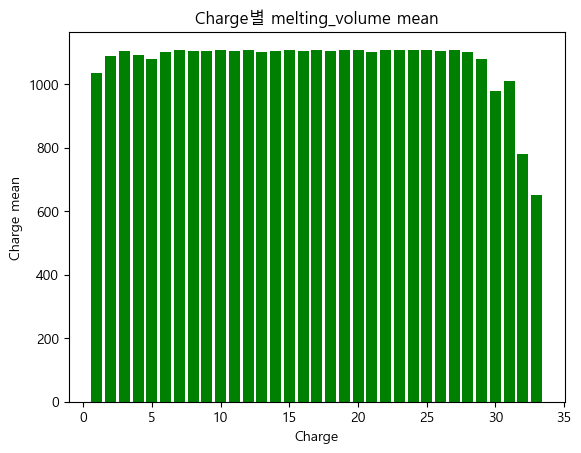

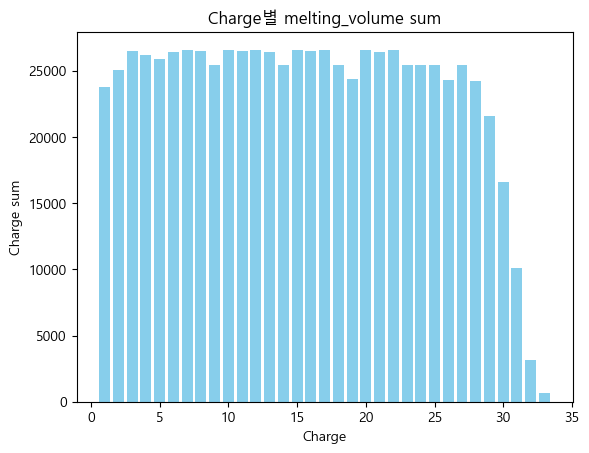

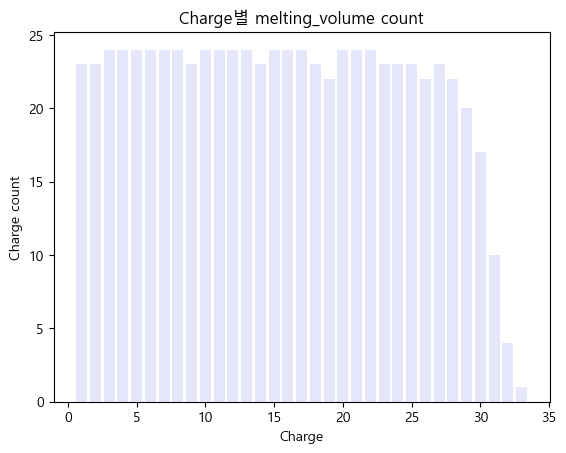

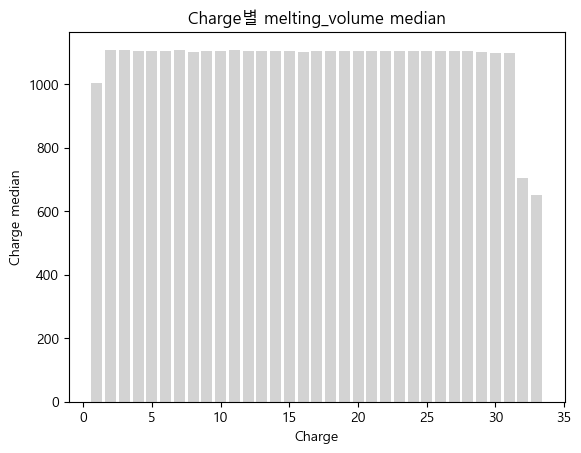

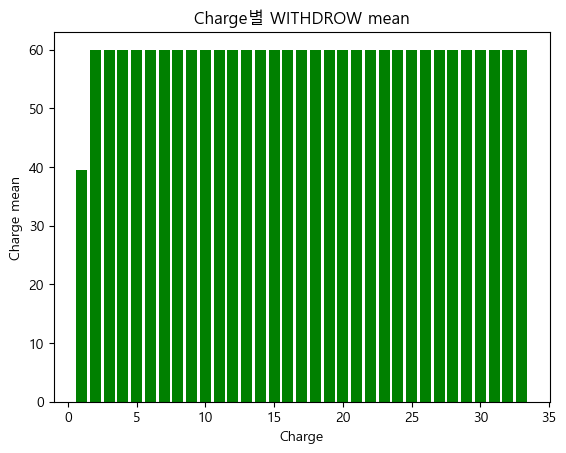

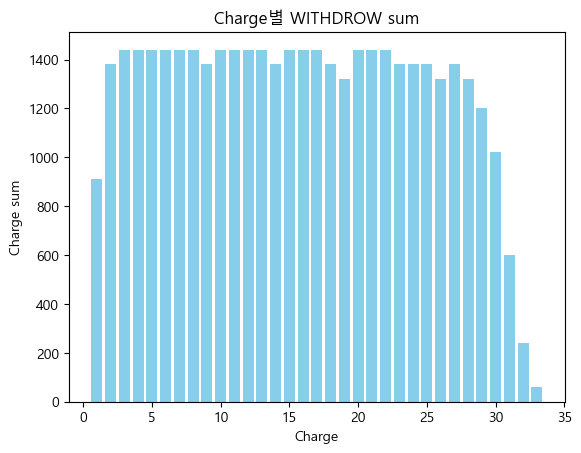

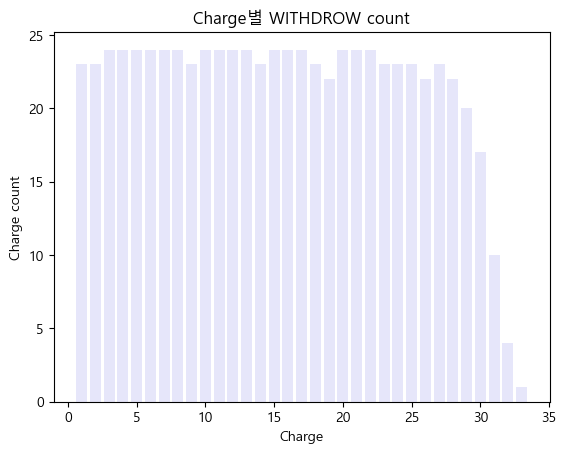

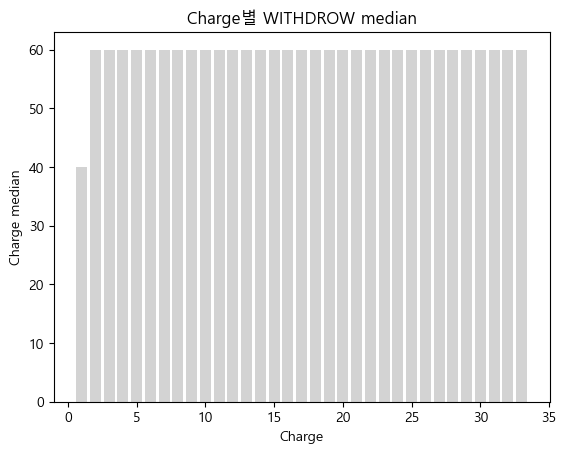

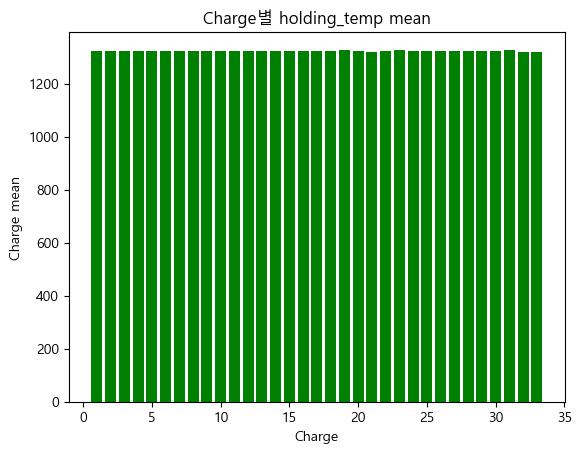

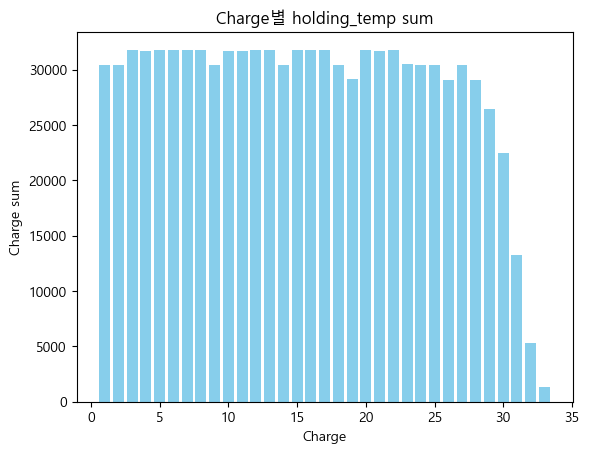

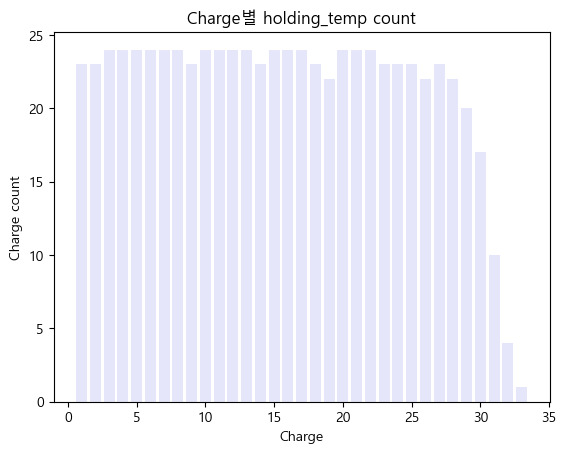

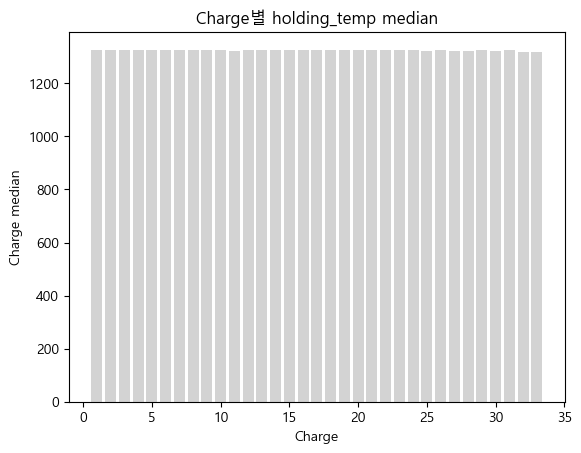

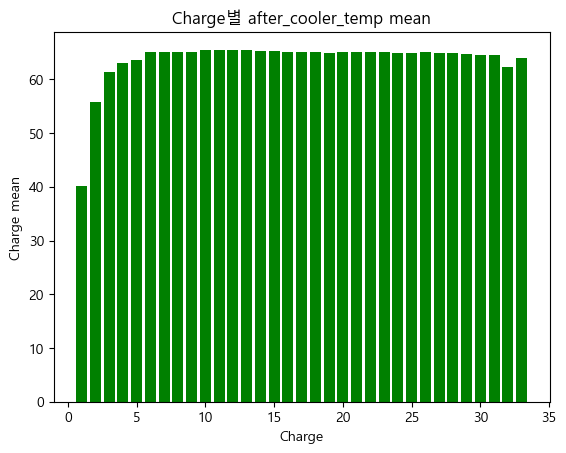

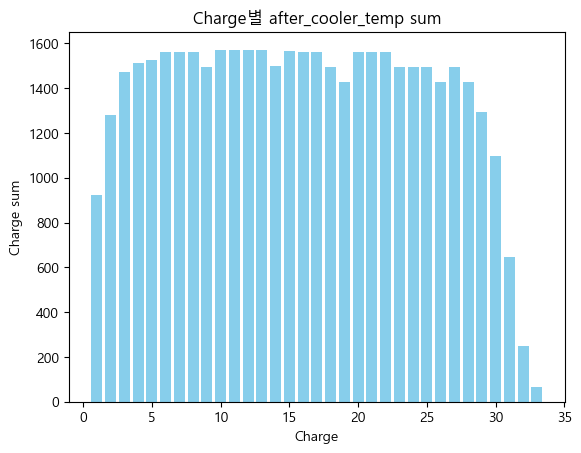

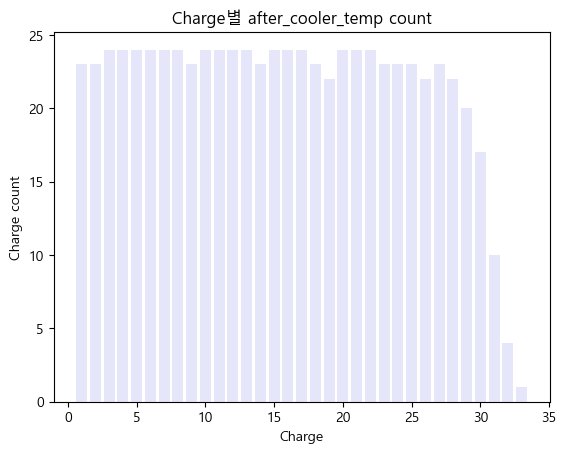

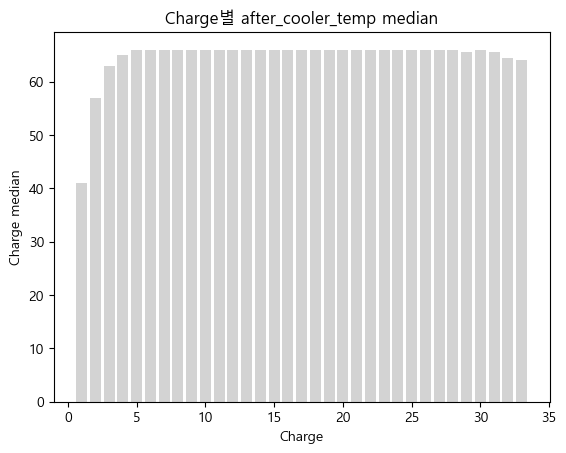

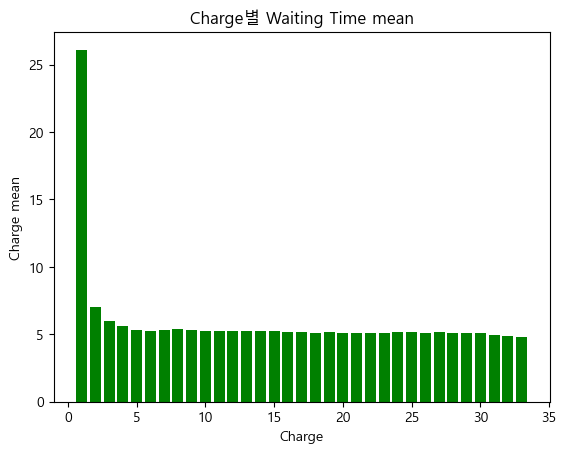

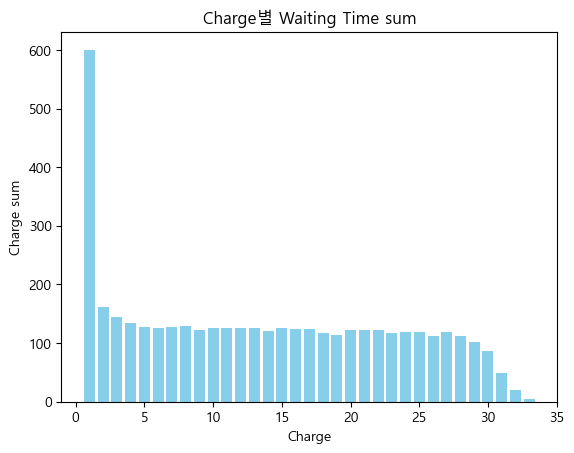

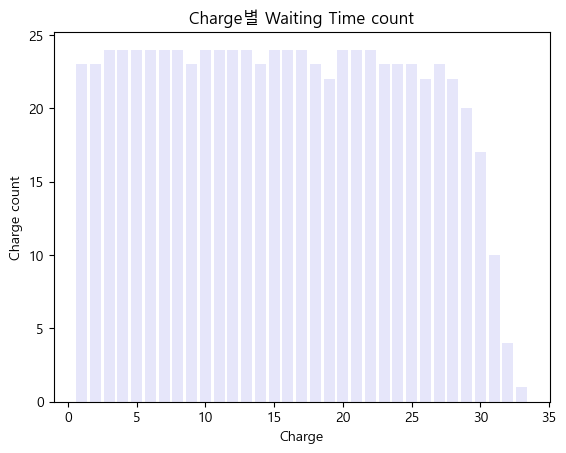

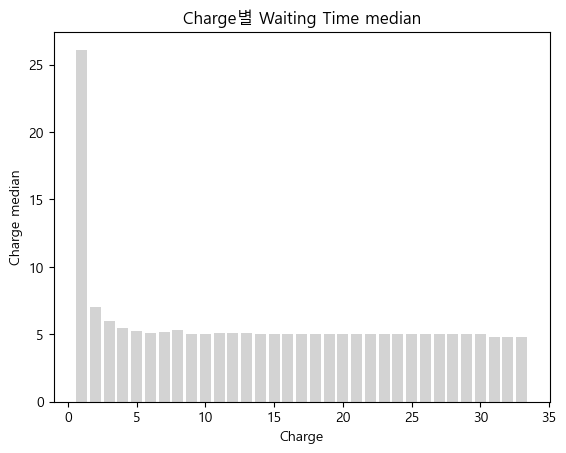

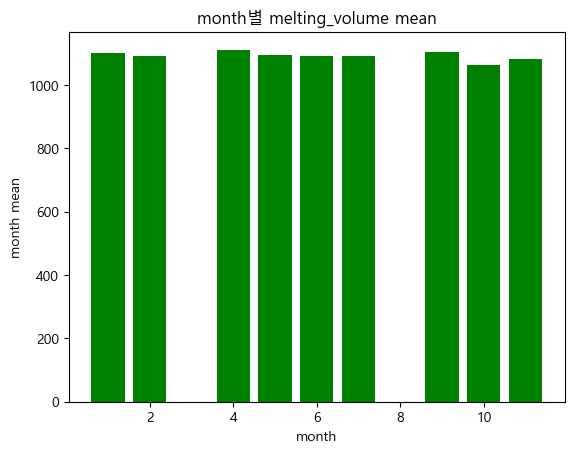

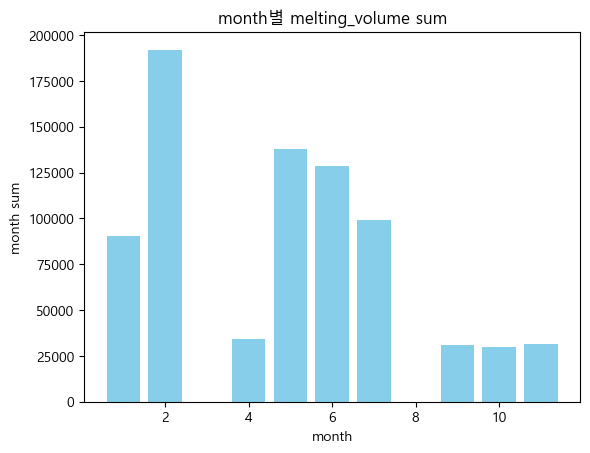

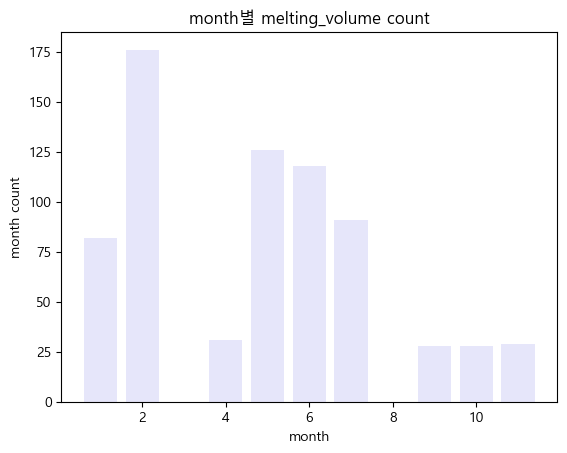

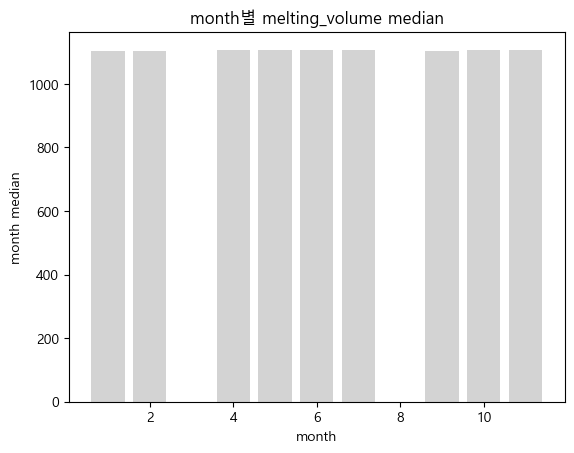

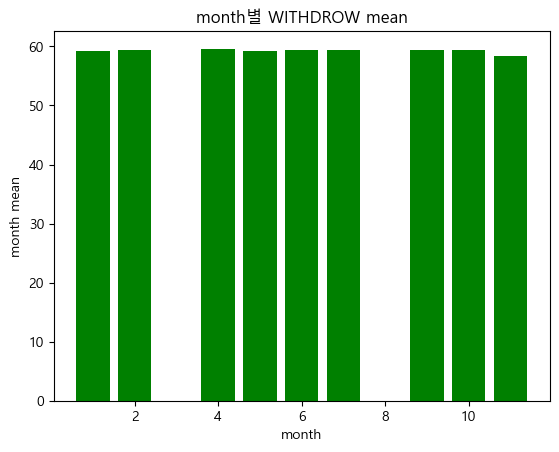

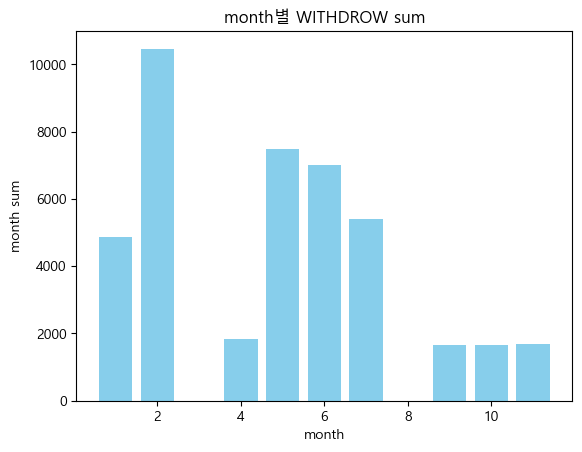

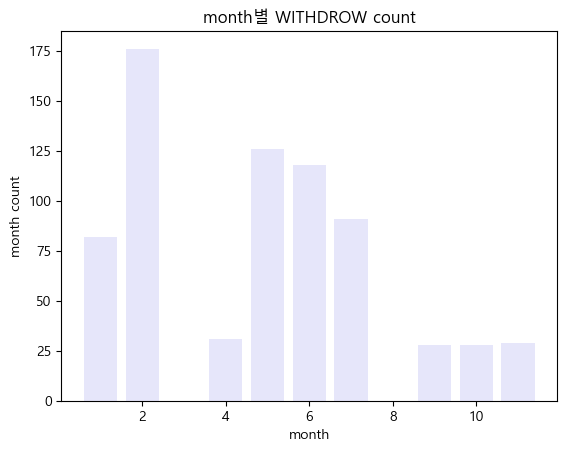

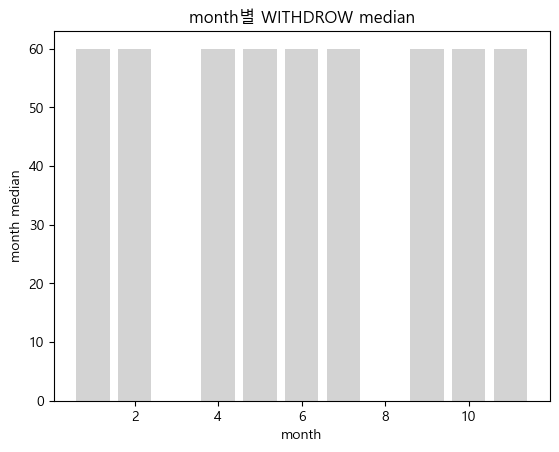

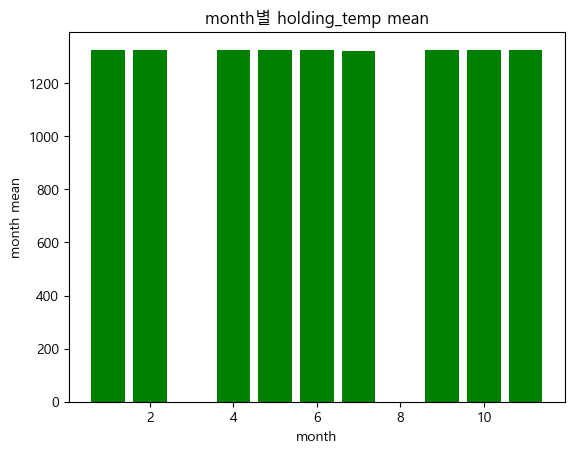

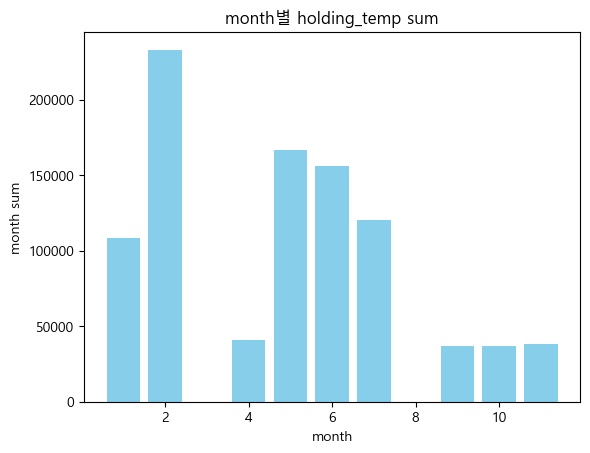

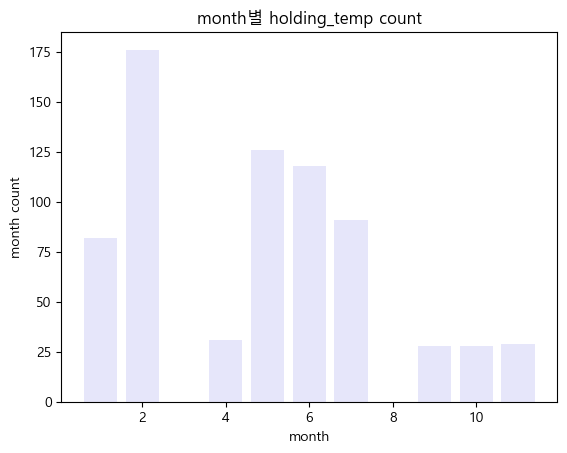

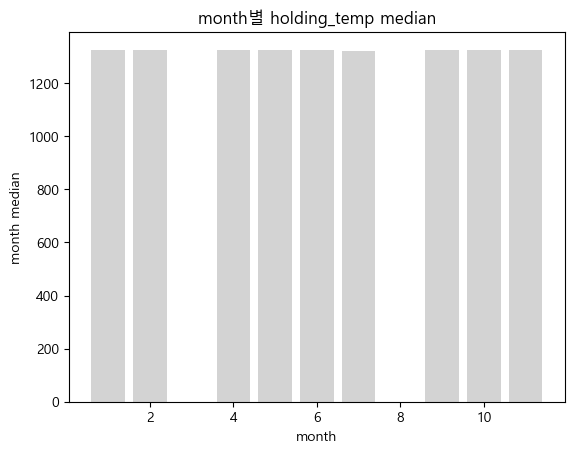

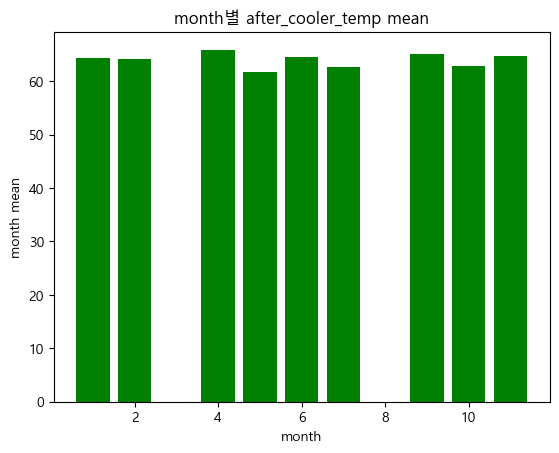

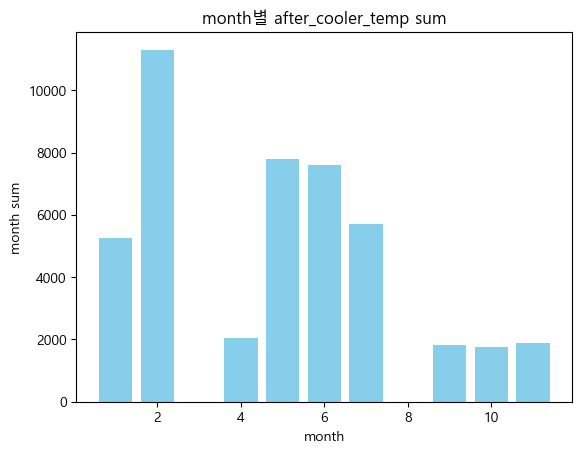

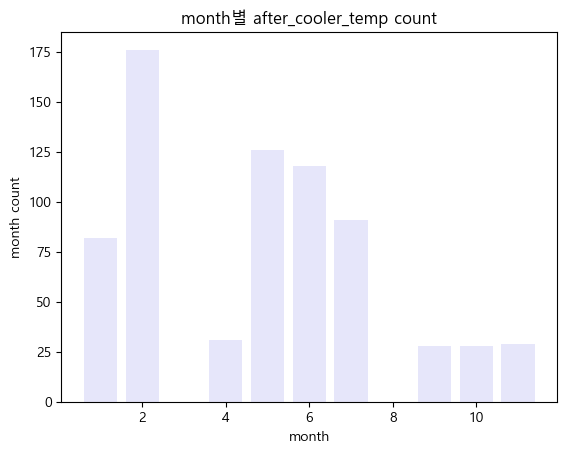

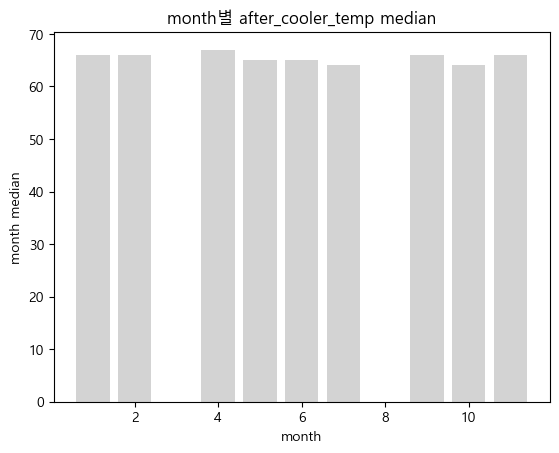

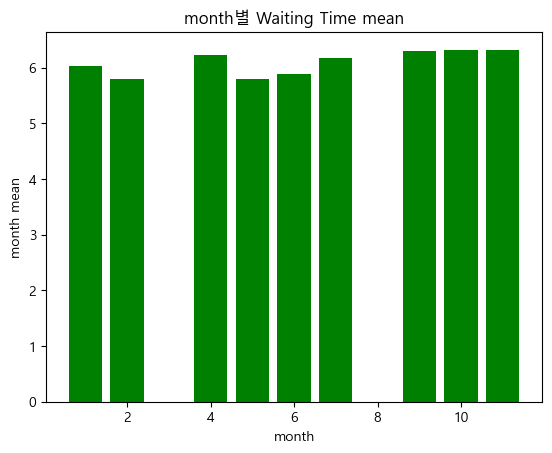

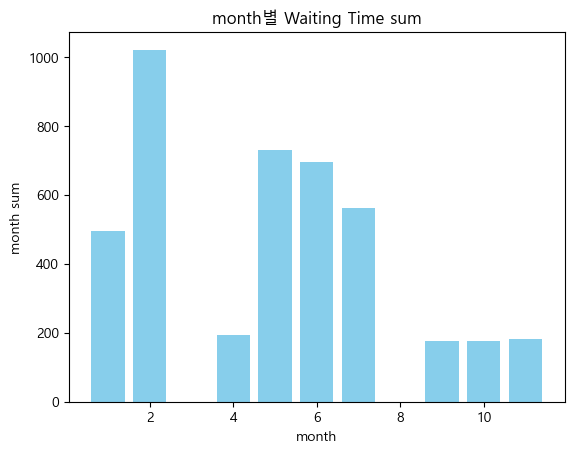

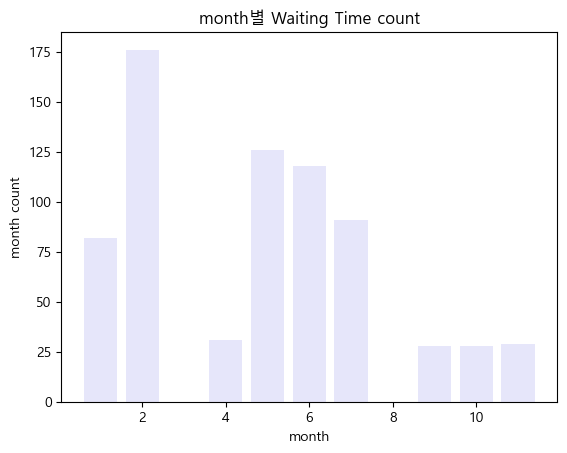

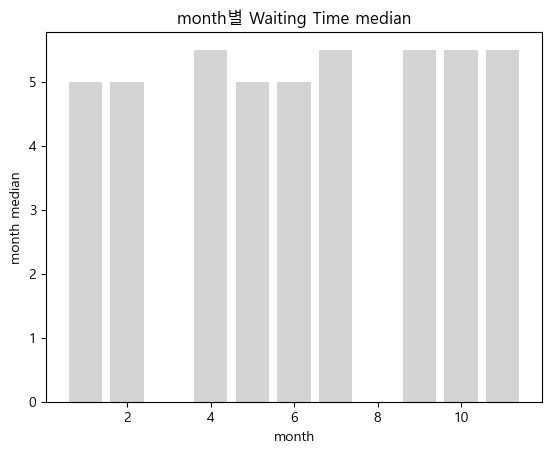

c:\Workspace\Hansbar\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


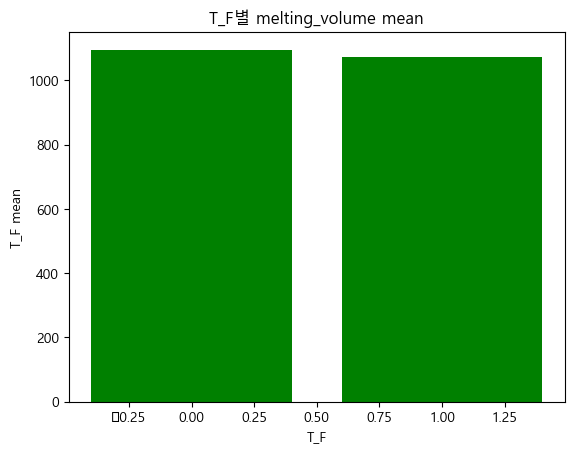

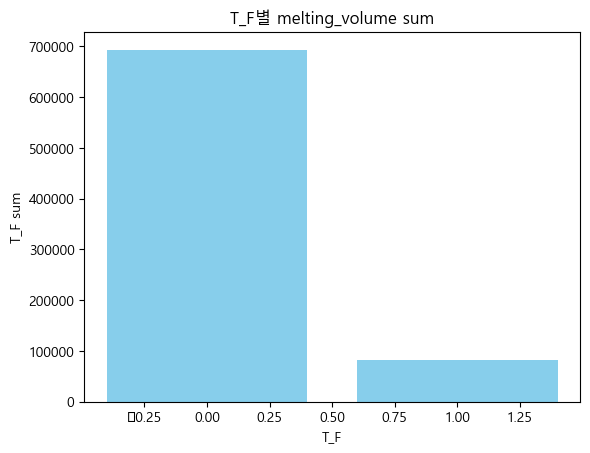

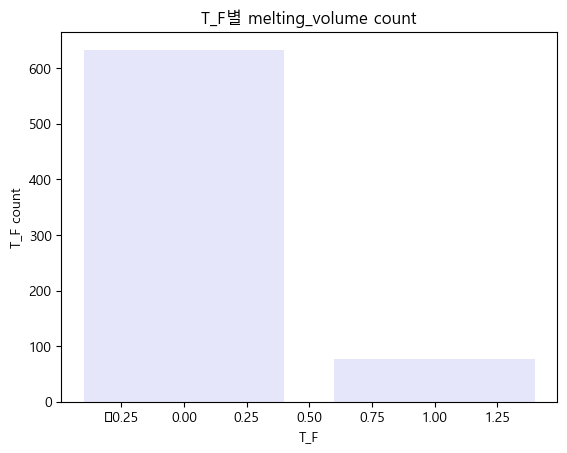

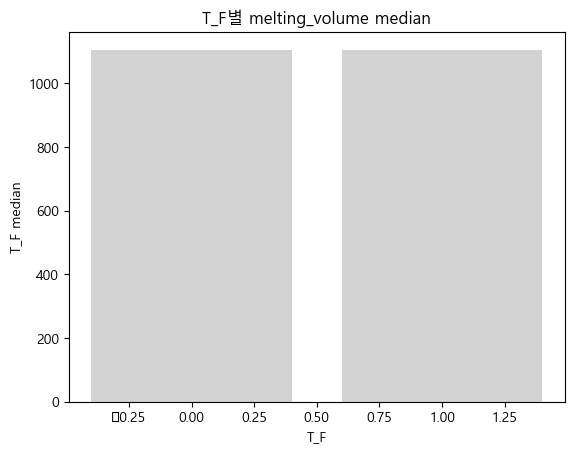

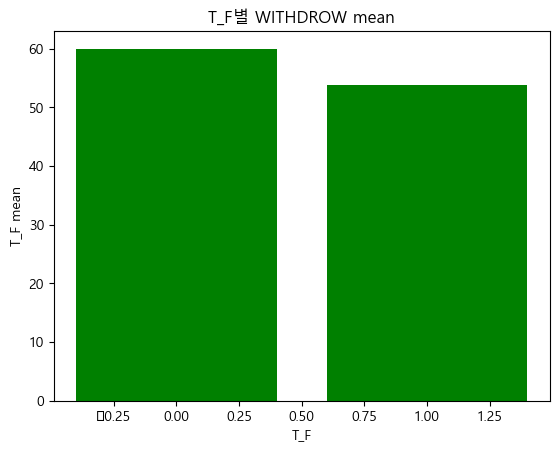

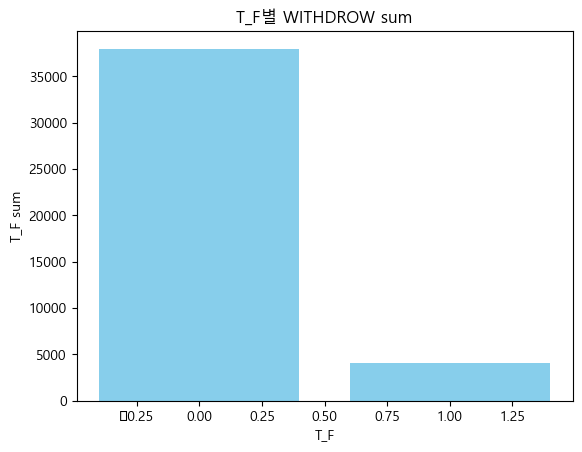

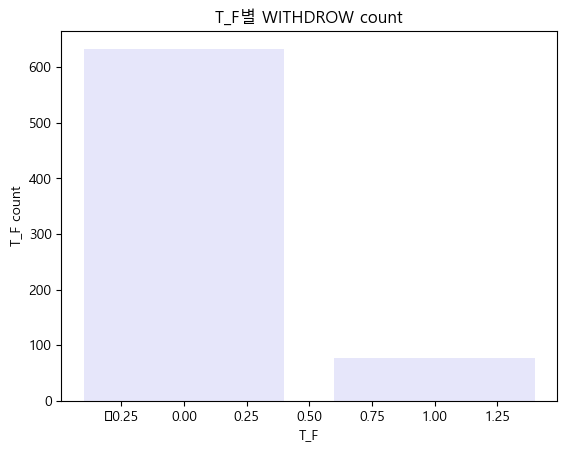

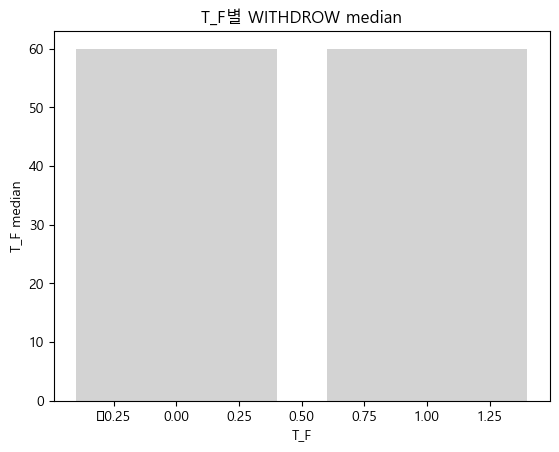

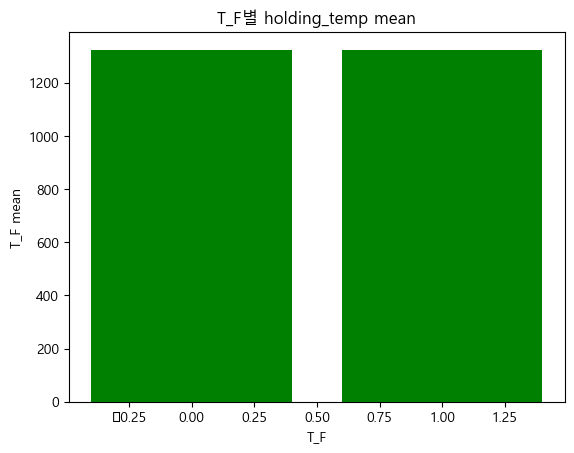

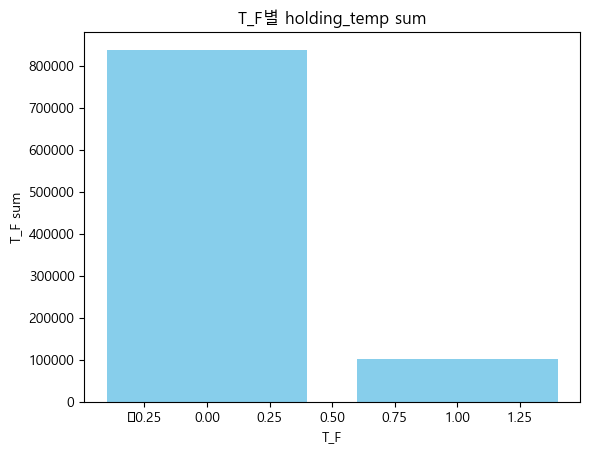

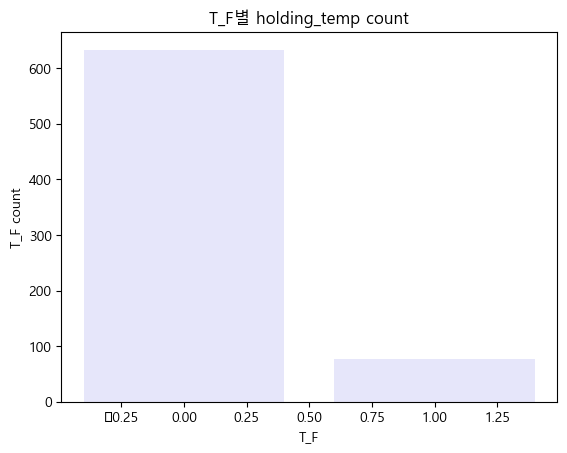

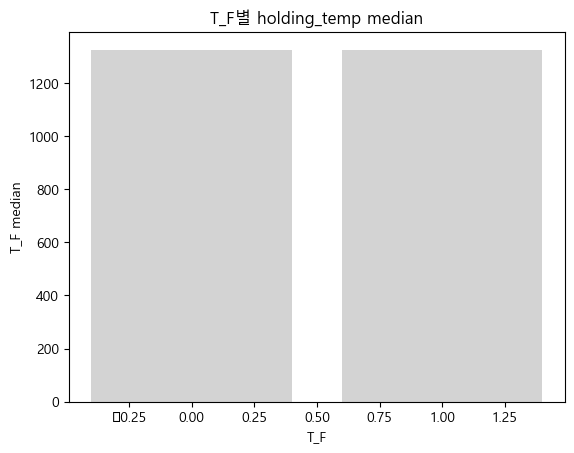

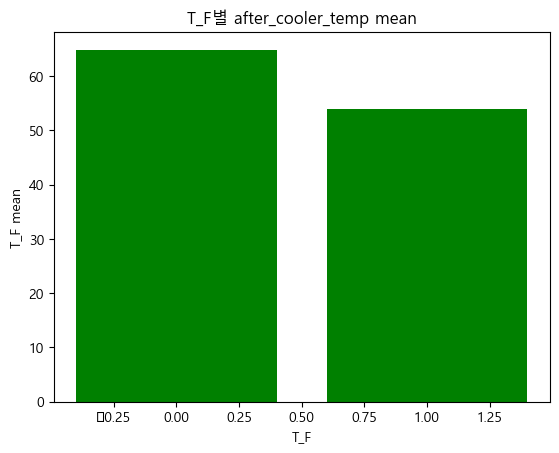

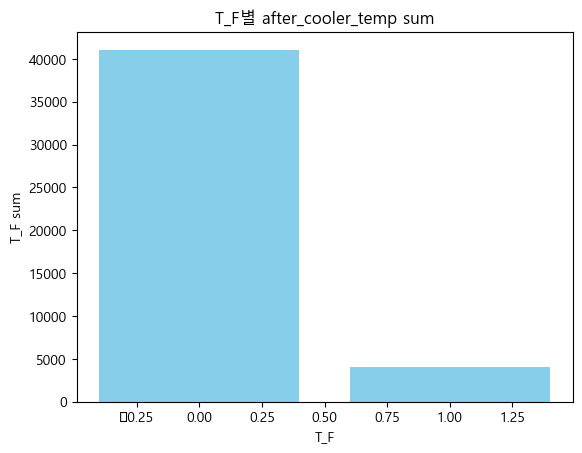

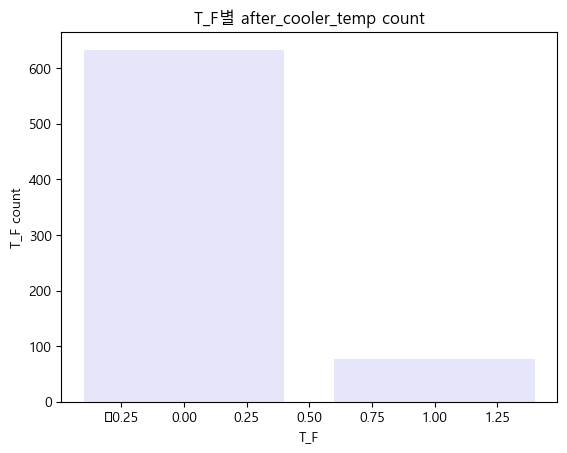

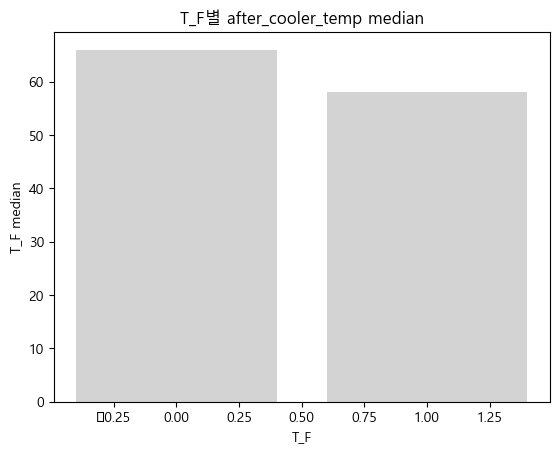

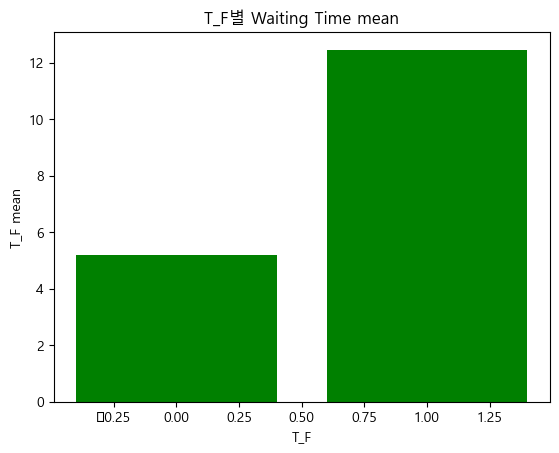

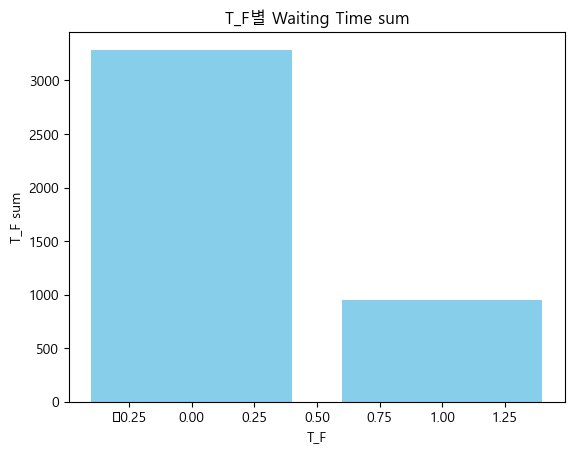

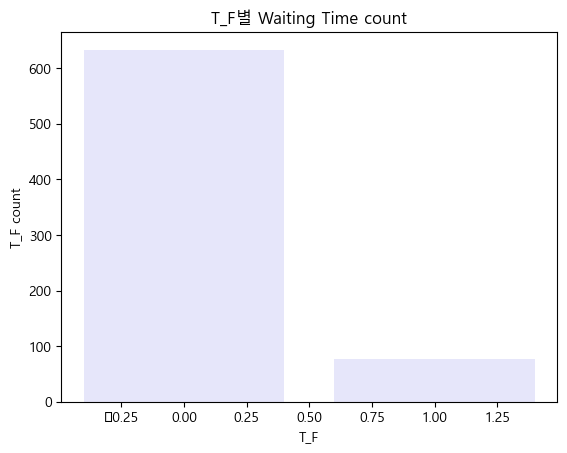

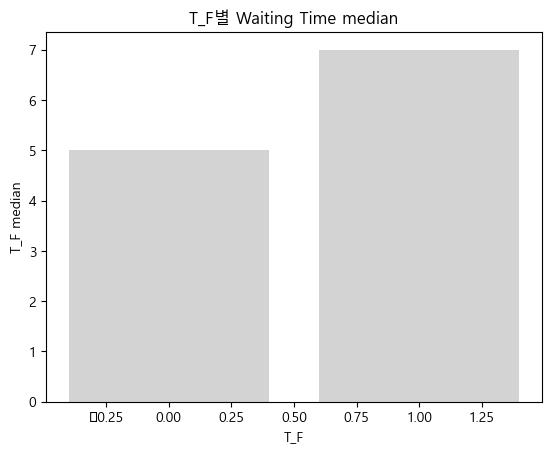

In [53]:
base_col = ['Charge','month','T_F']
value_col = ['melting_volume','WITHDROW','holding_temp','after_cooler_temp','Waiting Time']
funtion_ = ['mean','sum','count','median']
save_dir = 'EDA_240105_경도관련'#'EDA_12_22'

# base_col과 value_col를 함께 순회
for base in base_col:
    for value in value_col:
        # 그래프 그리는 코드 (funtion_에 대한 루프)
        for func in funtion_:
            make_bar_chart(base, value, func, save_dir)
            

In [30]:
original_dataset_df_v2_2023.head(3)

,type,ID,Charge,melting_volume,출탕시간,홀딩로투입시간,time_diff_melt_hold,holding_temp,Metal Temp Set,Metal Temp,...,after_cooler_temp,WITHDROW,Waiting Time,hardness,w.kg,mm/min,year,month,day,w_d/w_t
1,Original,20230116_01,1,1004,2023-01-16 09:19:00,2023-01-16 09:31:00,12,1328.0,950.0,929.0,...,38,42,26.1,300,166,86,2023,1,16,1.609195
3,Original,20230717_01,1,1111,2023-07-17 09:24:00,2023-07-17 09:31:00,7,1330.0,1070.0,1054.0,...,56,44,26.1,300,181,86,2023,7,17,1.685824
4,Original,20230215_01,1,1113,2023-02-15 09:16:00,2023-02-15 09:25:00,9,1328.0,970.0,947.0,...,41,52,26.1,300,231,100,2023,2,15,1.992337


In [31]:
# 사용하지 않는 변수 추가 제거 
original_dataset_df_v2_2023 = original_dataset_df_v2_2023.drop(labels=['출탕시간','홀딩로투입시간'],axis=1)
original_dataset_df_v2_2023.columns


Index(['type', 'ID', 'Charge', 'melting_volume', 'time_diff_melt_hold',
       'holding_temp', 'Metal Temp Set', 'Metal Temp', 'before_cooler_temp',
       'after_cooler_temp', 'WITHDROW', 'Waiting Time', 'hardness', 'w.kg',
       'mm/min', 'year', 'month', 'day', 'w_d/w_t'],
      dtype='object')

In [57]:

## profile 데이터 뽑기 히스토그램 or 상관관계 그래프 뽑기
#from ydata_profiling import ProfileReport
#pf_hansbar = ProfileReport(original_dataset_df_v2_2023_copy, title='Hansbar pf Report')
#pf_hansbar
#pf_hansbar.to_file("./hansbar_report_240103_afterhardness_t_f add.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Workspace\Hansbar\venv\lib\site-packages\ydata_profiling\visualisation\utils.py:73: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from current font.
  plt.savefig(
c:\Workspace\Hansbar\venv\lib\site-packages\ydata_profiling\visualisation\utils.py:73: UserWarning: Glyph 53461 (\N{HANGUL SYLLABLE TANG}) missing from current font.
  plt.savefig(
c:\Workspace\Hansbar\venv\lib\site-packages\ydata_profiling\visualisation\utils.py:73: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  plt.savefig(
c:\Workspace\Hansbar\venv\lib\site-packages\ydata_profiling\visualisation\utils.py:73: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from current font.
  plt.savefig(
c:\Workspace\Hansbar\venv\lib\site-packages\ydata_profiling\visualisation\utils.py:73: UserWarning: Glyph 54848 (\N{HANGUL SYLLABLE HOL}) missing from current font.
  plt.savefig(
c:\Workspace\Hansbar\venv\lib\site-packages\ydata_profiling\visualisation\utils.py:73: UserWarning: 

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [32]:
# profile 데이터 뽑기 히스토그램 or 상관관계 그래프 뽑기
from ydata_profiling import ProfileReport
pf_hansbar = ProfileReport(original_dataset_df_v2_2023, title='Hansbar pf Report')
pf_hansbar
pf_hansbar.to_file("./hansbar_report_240103_afterhardness.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [73]:
#argumentation_hansbar_hardness_df_T = argumentation_hansbar_hardness_df[argumentation_hansbar_hardness_df['hardness']<=230]
#argumentation_hansbar_hardness_df_F = argumentation_hansbar_hardness_df[argumentation_hansbar_hardness_df['hardness'] > 230]

original_dataset_df_v2_2023_T = original_dataset_df_v2_2023[original_dataset_df_v2_2023['hardness']<=230]
original_dataset_df_v2_2023_F = original_dataset_df_v2_2023[original_dataset_df_v2_2023['hardness']>230]

pf_hansbar_T = ProfileReport(original_dataset_df_v2_2023_T, title='Hansbar True product pf Report')
pf_hansbar_T.to_file("./hansbar_report_240105_양품.html")
pf_hansbar_F = ProfileReport(original_dataset_df_v2_2023_F, title='Hansbar False product pf Report')
pf_hansbar_F.to_file("./hansbar_report_240105_불양품.html")


c:\Workspace\Hansbar\venv\lib\site-packages\ydata_profiling\utils\dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Workspace\Hansbar\venv\lib\site-packages\ydata_profiling\utils\dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [44]:
original_dataset_df_v2_2023_T = original_dataset_df_v2_2023[original_dataset_df_v2_2023['hardness']<=230]
original_dataset_df_v2_2023_F = original_dataset_df_v2_2023[original_dataset_df_v2_2023['hardness']>230]

In [47]:
original_dataset_df_v2_2023_T.describe().T

,count,mean,min,25%,50%,75%,max,std
Charge,633.0,16.878357,3.0,10.0,17.0,24.0,33.0,8.000162
melting_volume,633.0,1095.338073,500.0,1102.0,1105.0,1109.0,1326.0,67.30788
출탕시간,633,2023-05-12 18:50:44.265402880,2023-01-10 10:40:00,2023-02-15 16:56:00,2023-05-19 12:45:00,2023-06-26 20:40:00,2023-11-02 21:03:00,NaN
홀딩로투입시간,633,2023-05-12 19:02:23.222748672,2023-01-10 10:51:00,2023-02-15 17:08:00,2023-05-19 13:19:00,2023-06-26 20:48:00,2023-11-02 21:08:00,NaN
time_diff_melt_hold,633.0,9.753555,3.0,9.0,10.0,11.0,24.0,2.342357
holding_temp,633.0,1323.870512,1303.0,1322.0,1324.0,1326.0,1425.0,5.867863
Metal Temp Set,633.0,1008.763897,677.0,970.0,988.0,1070.0,1163.0,67.1291
Metal Temp,633.0,1007.386359,864.0,968.0,986.0,1067.0,1198.0,66.172043
before_cooler_temp,633.0,39.35545,20.0,38.0,40.0,42.0,46.0,4.520177
after_cooler_temp,633.0,64.870458,38.0,64.0,66.0,66.0,69.0,3.42029


In [51]:
original_dataset_df_v2_2023_T.to_csv('PSO_dataset_01_08.csv',index=False,encoding='CP949')

In [48]:
original_dataset_df_v2_2023_F.describe().T

,count,mean,min,25%,50%,75%,max,std
Charge,76.0,4.368421,1.0,1.0,2.0,3.25,30.0,6.445344
melting_volume,76.0,1071.263158,800.0,1008.75,1105.0,1113.0,1127.0,67.907264
출탕시간,76,2023-04-28 00:55:52.105263104,2023-01-10 09:32:00,2023-02-02 10:33:00,2023-05-01 09:20:00,2023-07-01 15:39:45,2023-11-02 10:43:00,NaN
홀딩로투입시간,76,2023-04-28 01:05:39.473684480,2023-01-10 09:42:00,2023-02-02 10:40:15,2023-05-01 09:31:00,2023-07-01 15:49:00,2023-11-02 10:53:00,NaN
time_diff_melt_hold,76.0,9.789474,1.0,9.0,10.0,11.0,22.0,2.345582
holding_temp,76.0,1323.484072,1302.0,1322.0,1325.0,1327.0,1331.0,5.836454
Metal Temp Set,76.0,982.210526,860.0,939.25,968.5,1014.0,1170.0,72.424916
Metal Temp,76.0,971.802632,835.0,932.25,959.0,1002.0,1148.0,68.519198
before_cooler_temp,76.0,29.947368,12.0,24.0,30.5,36.5,40.0,7.431276
after_cooler_temp,76.0,53.907895,23.0,44.5,58.0,63.25,68.0,11.357438


In [29]:
# EDA 끝난 후 데이터 증강한 데이터 셋 컬럼 명 변경 및 파생변수 생성 선택 컬럼 구분
# EDA에 사용한 원본 데이터를 증강 데이터 셋에서 제거하기 outlier 또한 제외하기 (대전제는 학습 데이터는 정상 인발제품의 데이터로 가정함) 
# 학습용 : filterd_train_set.csv #증강 데이터 
# 검증용 : unseen_x, unseen_y
# 검증 데이터 구분하기 (사용 변수 정하기 / 검증 데이터 unseen_x, unseen_y 나누기)

In [32]:
# 증강 데이터 가져오기
argumentation_hansbar_df = pd.read_csv('MES_data_argumentation_with_outliers_152150ea.csv')

# 증강 데이터 파생변수 생성
argumentation_hansbar_df['w_d/w_t'] = argumentation_hansbar_df['WITHDROW'] / argumentation_hansbar_df['Waiting Time']

# 변수명 변경
#argumentation_hansbar_df = argumentation_hansbar_df.rename(columns ={"출탕량":"melting_volume",
#                                                                 "출탕투입시간차":"time_diff_melt_hold","실질홀딩로투입온도":"holding_temp",
#                                                                 "연주냉각 前 냉각수온도":"before_cooler_temp","연주냉각 後 냉각수온도":"after_cooler_temp",
#                                                                 "w.kg":"w_kg"})
argumentation_hansbar_df = argumentation_hansbar_df.rename(columns ={"출탕량":"melting_volume",
                                                                 "출탕투입시간차":"time_diff_melt_hold","실질홀딩로투입온도":"holding_temp",
                                                                 "연주냉각 前 냉각수온도":"before_cooler_temp","연주냉각 後 냉각수온도":"after_cooler_temp",
                                                                 "w.kg":"w_kg"})
# 변수 제거
argumentation_hansbar_df = argumentation_hansbar_df.drop(labels=['출탕시간','홀딩로투입시간','Date','호기','출탕_hour','출탕_minute','투입_hour','투입_minute','V%W','V%B','출탕_sec','투입_sec'],axis=1)

# 검증용 데이터 셋(original_dataset_df_v2_2022) & outlier 데이터 제거()

# 학습용 데이터 저장 => filterd_train_set.csv #증강 데이터 

In [33]:

# original_dataset_df_v2_2022과 공통으로 겹치는 데이터 행과 type outlier 데이터 날리기 !!!
argumentation_hansbar_df

,type,ID,Charge,melting_volume,time_diff_melt_hold,holding_temp,Metal Temp Set,Metal Temp,before_cooler_temp,after_cooler_temp,WITHDROW,Waiting Time,w_kg,mm/min,year,month,day,w_d/w_t
0,Normal,20221012_20,20,1108.000000,8.000000,1326.000000,1060.000000,1063.000000,42.000000,65.000000,60.000000,4.800000,23306.000000,600.000000,2023,10.0,12.0,12.500000
1,Outlier,19820729_24,24,2276.222344,4.545021,2975.715746,1948.712308,184.160388,79.405555,159.431455,132.133883,11.557039,13272.927003,1198.543609,2023,1.0,23.0,11.433195
2,Normal,20221024_10,10,1145.000000,9.000000,1326.000000,1116.000000,1115.000000,26.000000,65.000000,60.000000,5.000000,6041.000000,600.000000,2023,10.0,24.0,12.000000
3,Normal,20221101_14,14,1105.000000,9.000000,1325.000000,900.000000,896.000000,30.000000,68.000000,60.000000,5.000000,24013.000000,600.000000,2022,11.0,1.0,12.000000
4,Outlier,19750512_20,20,2232.637527,29.505547,2769.742995,168.969384,2447.387392,-0.235222,12.410609,146.894370,2.219396,22403.407280,110.231840,2023,5.0,28.0,66.186656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152145,Normal,20220811_22,22,1088.000000,11.000000,1324.000000,827.000000,824.000000,42.000000,63.000000,60.000000,6.000000,25062.000000,540.000000,2022,8.0,11.0,10.000000
152146,Normal,20221121_05,5,1108.000000,11.000000,1321.000000,950.000000,953.000000,27.500000,64.000000,60.000000,5.000000,4933.000000,660.000000,2022,11.0,21.0,12.000000
152147,Outlier,19830208_21,21,271.276224,21.918270,234.137264,2082.347676,1999.293424,-1.193097,139.398136,6.090756,0.506728,21066.624615,1192.216288,2023,2.0,13.0,12.019763
152148,Outlier,19790821_04,4,2670.979230,20.812447,2970.071500,2286.131893,310.621439,66.751569,-1.949308,148.641584,0.864723,901.286547,83.903810,2022,3.0,2.0,171.895046


In [34]:
len(argumentation_hansbar_df[argumentation_hansbar_df['type']=='Outlier'])

25917

In [35]:
152150 - 25917

126233

In [36]:
126233 - 84420

41813

In [37]:
# 증강 데이터 중 이상치 제거
argumentation_hansbar_df_v1 = argumentation_hansbar_df[argumentation_hansbar_df['type']!='Outlier']

# 2022년 검증 데이터의 ID 
values_to_exclude = original_dataset_df_v2_2022['ID'].to_list()

# Name이 values_to_exclude에 포함되지 않는 행 선택
df_filtered = argumentation_hansbar_df_v1[~argumentation_hansbar_df_v1['ID'].isin(values_to_exclude)].reset_index(drop=True)
df_filtered


,type,ID,Charge,melting_volume,time_diff_melt_hold,holding_temp,Metal Temp Set,Metal Temp,before_cooler_temp,after_cooler_temp,WITHDROW,Waiting Time,w_kg,mm/min,year,month,day,w_d/w_t
0,Normal,20230717_03,3,1102.0,9.0,1318.0,1074.0,1064.0,42.00,61.0,60.0,5.5,4829.0,540.0,2022,7.0,17.0,10.909091
1,Normal,20230515_17,17,1124.0,10.0,1321.0,1083.0,1076.0,32.00,66.0,60.0,4.8,3568.0,600.0,2023,5.0,15.0,12.500000
2,Normal,20230626_14,14,1109.0,7.0,1220.0,1008.0,997.0,38.00,64.0,60.0,4.8,149.0,600.0,2023,6.0,26.0,12.500000
3,Normal,20230626_27,27,1094.0,6.0,1312.0,1011.0,1014.0,38.00,64.0,60.0,4.8,149.0,600.0,2022,6.0,26.0,12.500000
4,Normal,20230215_22,22,1096.0,8.0,1319.0,979.0,983.0,42.00,63.0,60.0,5.5,21551.0,540.0,2022,2.0,15.0,10.909091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84415,Normal,20230515_27,27,1135.0,13.0,1325.0,1082.0,1081.0,32.00,66.0,60.0,4.8,3568.0,600.0,2023,5.0,15.0,12.500000
84416,Normal,20221101_25,25,1101.0,7.0,1326.0,908.0,908.0,30.00,65.0,60.0,5.0,29062.0,600.0,2022,11.0,1.0,12.000000
84417,Normal,20230626_17,17,1098.0,3.0,1350.0,1004.0,1004.0,38.00,64.0,60.0,4.8,149.0,600.0,2022,6.0,26.0,12.500000
84418,Normal,20230126_11,11,1100.0,13.0,1325.0,934.0,925.0,25.25,67.0,60.0,5.0,11362.0,540.0,2023,1.0,26.0,12.000000


In [78]:
# 모델 학습위한 데이터 셋
df_filtered.to_csv('train_data_12_22.csv')

In [50]:

#df_filtered_drop = df_filtered.drop(labels=['type','ID','year','month','day'],axis=1)
#df_filtered_drop2 = df_filtered_drop[df_filtered_drop['Charge']!=0]
#df_filtered_drop2.to_csv('unseen_data_01_03_hardness.csv',index=False)

In [28]:
# 증강 데이터 가져오기
argumentation_hansbar_hardness_df = pd.read_csv('train_data_01_03_after_hardness.csv')


In [29]:
argumentation_hansbar_hardness_df[['hardness','before_cooler_temp','w_d/w_t']] = round(argumentation_hansbar_hardness_df[['hardness','before_cooler_temp','w_d/w_t']],0)
argumentation_hansbar_hardness_df['Waiting Time'] = round(argumentation_hansbar_hardness_df['Waiting Time'],1)

In [30]:
argumentation_hansbar_hardness_df.head(5)

,Charge,melting_volume,time_diff_melt_hold,holding_temp,Metal Temp Set,Metal Temp,before_cooler_temp,after_cooler_temp,WITHDROW,Waiting Time,w_kg,mm/min,w_d/w_t,hardness
0,3,1102,9,1318,1074,1064,42.0,61,60,5.5,4829,540,11.0,197.0
1,17,1124,10,1321,1083,1076,32.0,66,60,4.8,3568,600,12.0,195.0
2,14,1109,7,1220,1008,997,38.0,64,60,4.8,149,600,12.0,192.0
3,27,1094,6,1312,1011,1014,38.0,64,60,4.8,149,600,12.0,192.0
4,22,1096,8,1319,979,983,42.0,63,60,5.5,21551,540,11.0,201.0


In [58]:
len(argumentation_hansbar_hardness_df)

84125

In [31]:
print('경도 230 이하 정상 제품 개수:',len(argumentation_hansbar_hardness_df[argumentation_hansbar_hardness_df['hardness'] <= 230]))
print('경도 230 초과 불량 제품 개수:',len(argumentation_hansbar_hardness_df[argumentation_hansbar_hardness_df['hardness'] > 230]))

경도 230 이하 정상 제품 개수: 82376
경도 230 초과 불량 제품 개수: 1749


In [32]:
argumentation_hansbar_hardness_df_T = argumentation_hansbar_hardness_df[argumentation_hansbar_hardness_df['hardness']<=230]
argumentation_hansbar_hardness_df_F = argumentation_hansbar_hardness_df[argumentation_hansbar_hardness_df['hardness'] > 230]

In [33]:
argumentation_hansbar_hardness_df_T

,Charge,melting_volume,time_diff_melt_hold,holding_temp,Metal Temp Set,Metal Temp,before_cooler_temp,after_cooler_temp,WITHDROW,Waiting Time,w_kg,mm/min,w_d/w_t,hardness
0,3,1102,9,1318,1074,1064,42.0,61,60,5.5,4829,540,11.0,197.0
1,17,1124,10,1321,1083,1076,32.0,66,60,4.8,3568,600,12.0,195.0
2,14,1109,7,1220,1008,997,38.0,64,60,4.8,149,600,12.0,192.0
3,27,1094,6,1312,1011,1014,38.0,64,60,4.8,149,600,12.0,192.0
4,22,1096,8,1319,979,983,42.0,63,60,5.5,21551,540,11.0,201.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84120,27,1135,13,1325,1082,1081,32.0,66,60,4.8,3568,600,12.0,195.0
84121,25,1101,7,1326,908,908,30.0,65,60,5.0,29062,600,12.0,202.0
84122,17,1098,3,1350,1004,1004,38.0,64,60,4.8,149,600,12.0,192.0
84123,11,1100,13,1325,934,925,25.0,67,60,5.0,11362,540,12.0,206.0


In [35]:
argumentation_hansbar_hardness_df_F

,Charge,melting_volume,time_diff_melt_hold,holding_temp,Metal Temp Set,Metal Temp,before_cooler_temp,after_cooler_temp,WITHDROW,Waiting Time,w_kg,mm/min,w_d/w_t,hardness
34,2,1108,9,1321,962,954,24.0,70,60,6.0,2236,540,10.0,251.0
65,3,1094,15,1325,970,970,26.0,41,60,6.0,2201,480,10.0,232.0
266,15,1117,12,1339,928,934,28.0,66,60,6.0,17233,420,10.0,242.0
267,4,1103,11,1333,934,939,22.0,67,60,5.5,6205,480,11.0,232.0
325,19,1097,7,1326,941,942,30.0,68,60,6.0,20123,600,10.0,247.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83957,7,1095,4,1315,993,994,35.0,64,60,6.0,12955,480,10.0,231.0
84049,5,1108,7,1318,962,954,24.0,58,60,6.0,2236,540,10.0,243.0
84054,4,1097,11,1325,900,899,15.0,65,60,5.5,3545,480,11.0,234.0
84067,13,1095,8,1326,937,930,28.0,66,60,6.0,14921,540,10.0,245.0


In [38]:

argumentation_hansbar_hardness_df_T.to_csv('hardness_true_data_0105.csv',index=False)
argumentation_hansbar_hardness_df_F.to_csv('hardness_false_data_0105.csv',index=False)
argumentation_hansbar_hardness_df.to_csv('hardness_t_f_data_0105.csv',index=False)

argumentation_hansbar_df_T_train = argumentation_hansbar_hardness_df_T.drop(labels=['hardness'],axis=1)
argumentation_hansbar_df_T_train.to_csv('train_data_0105_hardness_T.csv',index=False)


In [37]:
argumentation_hansbar_df_T_train['WITHDROW'].unique()

array([60], dtype=int64)

In [30]:
pause !!!!!!!!!!!!!!!!!!!!

SyntaxError: invalid syntax (1367209203.py, line 1)

In [52]:
import pandas as pd
import numpy as np

def calculate_metrics(actual, predicted):
    """
    Calculate MAE, MAPE, and RMSE.

    Parameters:
    actual (pd.Series): Actual values.
    predicted (pd.Series): Predicted values.

    Returns:
    dict: Dictionary containing MAE, MAPE, and RMSE.
    """
    # Calculate MAE
    mae = np.abs(actual - predicted).mean()

    # Calculate MAPE
    mape = (np.abs((actual - predicted) / actual) * 100).mean()

    # Calculate RMSE
    rmse = np.sqrt(((actual - predicted) ** 2).mean())

    return {'MAE': mae, 'MAPE': mape, 'RMSE': rmse}

# 예시 데이터 생성



#data = {'Actual': [10, 15, 20, 25, 30],
#        'Predicted': [12, 18, 22, 24, 28]}
df22 = pd.read_csv('C:\Workspace\Hansbar\Model\First_time\Regression\Evaluation\SVR_prediction_value.csv')


# 함수 호출하여 메트릭스 계산
metrics = calculate_metrics(df22['True Values'], df22['Predict'])

# 결과 출력
print(metrics)

{'MAE': 0.9613642007587253, 'MAPE': 0.46833720415317154, 'RMSE': 2.018721377432494}


In [ ]:
eda_origin_df = pd.read_csv('EDA_data.csv',index_col=0)

In [ ]:
eda_origin_df

In [ ]:
import pandas as pd
# 예시 데이터 프레임
data = {'Numeric1': [10, 20, 30, 40, 50],
        'Numeric2': [0.1, 0.2, 0.3, 0.4, 0.5],
        'Category': [1, 2, 3, 4, 5]}

df_tmep = pd.DataFrame(data)

In [ ]:
df_tmep

In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import joblib

# 범주형과 수치형 열을 나누기
categorical_columns = ['Category']
numeric_columns = ['Numeric1','Numeric2']

## One-Hot Encoding과 스케일링을 위한 ColumnTransformer
#preprocessor = ColumnTransformer(
#    transformers=[
#        ('cat', OneHotEncoder(), categorical_columns),
#        ('num', StandardScaler(), numeric_columns),
#    ],
#    remainder='passthrough'
#)
if len(categorical_columns) != 0:
    print('수치형 & 명목형')
    # One-Hot Encoding과 스케일링을 위한 ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), categorical_columns),
            ('num', StandardScaler(), numeric_columns),
        ],
        remainder='passthrough'
    )
else :
    print('수치형 only')
    # One-Hot Encoding과 스케일링을 위한 ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), categorical_columns),
            ('num', StandardScaler(), numeric_columns),
        ],
        remainder='passthrough'
    )  


# 전처리를 위한 전체 파이프라인
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# 데이터 변환과 스케일링
transformed_data2 = pipeline.fit_transform(df_tmep)

print('transformed_data===>',transformed_data2)

In [ ]:
transformed_data2

In [ ]:
df = pd.read_csv('test_X_train.csv')
df

In [ ]:
# 범주형과 수치형 열을 나누기
categorical_columns = ['Charge']
numeric_columns = ['melting_volume', 'time_diff_melt_hold', 'holding_temp', 'Metal Temp Set', 'Metal Temp', 'before_cooler_temp', 'after_cooler_temp', 'Waiting Time', 'w_kg', 'mm/min', 'w_d/w_t']
#numeric_columns = ['melting_volume', 'time_diff_melt_hold'
## One-Hot Encoding과 스케일링을 위한 ColumnTransformer
#preprocessor = ColumnTransformer(
#    transformers=[
#        ('cat', OneHotEncoder(), categorical_columns),
#        ('num', StandardScaler(), numeric_columns),
#    ],
#    remainder='passthrough'
#)
if len(categorical_columns) != 0:
    print('수치형 & 명목형')
    # One-Hot Encoding과 스케일링을 위한 ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), categorical_columns),
            ('num', StandardScaler(), numeric_columns),
        ],
        remainder='passthrough'
    )
else :
    print('수치형 only')
    # One-Hot Encoding과 스케일링을 위한 ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), categorical_columns),
            ('num', StandardScaler(), numeric_columns),
        ],
        remainder='passthrough'
    )  


# 전처리를 위한 전체 파이프라인
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# 데이터 변환과 스케일링
transformed_data = pipeline.fit_transform(df)

# 희소 행렬이 아닌 일반적인 2차원 배열로 변환
dense_array_result = transformed_data.toarray()

print('transformed_data===>',dense_array_result)

In [ ]:
transformed_data

In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import joblib

#df = pd.read_csv('test_X_train.csv')

# 범주형과 수치형 열을 나누기
categorical_columns = ['Charge']
numeric_columns = ['melting_volume', 'time_diff_melt_hold', 'holding_temp', 'Metal Temp Set', 'Metal Temp', 'before_cooler_temp', 'after_cooler_temp', 'Waiting Time', 'w_kg', 'mm/min', 
'w_d/w_t']

## One-Hot Encoding과 스케일링을 위한 ColumnTransformer
#preprocessor = ColumnTransformer(
#    transformers=[
#        ('cat', OneHotEncoder(), categorical_columns),
#        ('num', StandardScaler(), numeric_columns),
#    ],
#    remainder='passthrough'
#)
if len(categorical_columns) != 0:
    print('수치형 & 명목형')
    # One-Hot Encoding과 스케일링을 위한 ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), categorical_columns),
            ('num', StandardScaler(), numeric_columns),
        ],
        remainder='passthrough'
    )
else :
    print('수치형 only')
    # One-Hot Encoding과 스케일링을 위한 ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), categorical_columns),
            ('num', StandardScaler(), numeric_columns),
        ],
        remainder='passthrough'
    )  


# 전처리를 위한 전체 파이프라인
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# 데이터 변환과 스케일링
transformed_data = pipeline.fit_transform(df)

print('transformed_data===>',transformed_data)

total_tranformed_len = len(transformed_data[0])
print('total_tranformed_len',total_tranformed_len)
numeric_columns_len = len(numeric_columns)
print('numeric_columns_len',numeric_columns_len)
categorical_columns_len = total_tranformed_len - numeric_columns_len
print('categorical_columns_len',categorical_columns_len)


# 모델 저장
joblib.dump(pipeline, 'preprocessing_model.pkl')



# 모델 불러오기
loaded_pipeline = joblib.load('preprocessing_model.pkl')

# 새로운 데이터 변환
new_data = pd.DataFrame({'Numeric1': [25],'Category': [1], 'Numeric2': [0.25]})
transformed_new_data = loaded_pipeline.named_steps['preprocessor'].transform(new_data)

# 역변환을 위한 각 변환기에 대한 역변환 적용
inverse_transformed_data = pd.DataFrame(columns=df.columns)

# 명목 변수에 대한 역변환 결과를 데이터프레임에 추가
inverse_transformed_data[categorical_columns] = loaded_pipeline.named_steps['preprocessor'] \
    .named_transformers_['cat'].inverse_transform(transformed_new_data[:, :categorical_columns_len])
    

# 수치 변수에 대한 역변환 결과를 데이터프레임에 추가
inverse_transformed_data[numeric_columns] = loaded_pipeline.named_steps['preprocessor'] \
    .named_transformers_['num'].inverse_transform(transformed_new_data[:, categorical_columns_len:])

# 결과 출력
print("\n새로운 데이터:")
print(new_data)
print("\n역변환된 새로운 데이터:")
print(inverse_transformed_data)

In [ ]:
import numpy as np
TEMP_ = pd.read_csv('C:\Workspace\Hansbar\Dataset\Common\Made_2023-12-21_09-57\X_train.csv')
X_temmp = np.array(TEMP_)


In [ ]:
len(X_temmp)

In [ ]:
TEMP_

In [ ]:
pd.read_csv('C:\Workspace\Hansbar\Dataset\Common\Made_2023-12-21_10-38\Original_data\validation_data_X.csv')

In [ ]:
import numpy as np
from pyswarm import pso

# 최적화하고자 하는 목적 함수 정의 (예시 함수)
def objective_function(x):
    # 예시로 x의 제곱을 최소화하는 문제
    return x[0]**2 + x[1]**2

# 정수로 반올림하는 목적 함수 정의
def integer_objective_function(x):
    # 실수 목적 함수 호출 후 정수로 반올림
    return objective_function(np.round(x))

# 파티클 스웜 최적화 실행
lb = [-5, -5]  # 변수의 최소값
ub = [5, 5]    # 변수의 최대값
x_optimal, f_optimal = pso(integer_objective_function, lb, ub)

# 결과 출력
print("최적 해:", x_optimal)
print("최적 값:", f_optimal)

In [ ]:
import numpy as np
from pyswarm import pso

# 최적화하고자 하는 목적 함수 정의 (예시 함수)
def objective_function(x):
    # 여기에서는 간단한 예시 함수를 사용하겠습니다.
    return np.sum(x**2)

# 제약 함수 정의 (특정 변수의 합이 10 이상이어야 함)
def constraint_function(x):
    return np.sum(x) - 10

# 상한과 하한을 정의
lb = [0, 0, 0, 0, 0]  # 변수의 최소값
ub = [5, 5, 5, 5, 5]  # 변수의 최대값

constraint_function_list = [constraint_function]

# 파티클 스웜 최적화 실행
x_optimal, f_optimal = pso(objective_function, lb, ub, f_ieqcons=constraint_function_list)

# 최적해와 최적값 출력
print("최적 해:", x_optimal)
print("최적 값:", f_optimal)

In [ ]:
X_train_col =  ['Charge', 'melting_volume', 'time_diff_melt_hold', 'holding_temp', 'Metal Temp Set', 'Metal Temp', 'before_cooler_temp', 'after_cooler_temp', 'Waiting Time', 'w_kg', 'mm/min', 'w_d/w_t']
x2 = [9.751626770615879, 1215.3520982323057, 16.02630747891766, 1314.4552519691258, 403.3300637465171, 305.2245370526001, 26.837007399528765, 55.16544029939553, 21.0102073176498, 30819.4280769221, 359.56287564772725, 4.023781049997583]


In [ ]:
t_df = pd.DataFrame(x2).T
t_df.columns = X_train_col

In [ ]:
t_df

In [ ]:
t_df['Charge'] = np.round(t_df['Charge'])

In [ ]:
t_df

In [85]:
import numpy as np
from scipy import stats

# 표본 데이터 생성
sample_data = np.array([25, 28, 22, 30, 18, 24, 28, 20, 32, 26])

# 표본 평균 계산
sample_mean = np.mean(sample_data)

# 신뢰 구간 계산 (95% 신뢰도를 가정)
confidence_interval = stats.t.interval(0.95, len(sample_data)-1, loc=sample_mean, scale=stats.sem(sample_data))

# 결과 출력
print(f"표본 평균: {sample_mean}")
print(f"95% 신뢰 구간: {confidence_interval}")

표본 평균: 25.3
95% 신뢰 구간: (22.135674162380454, 28.464325837619548)


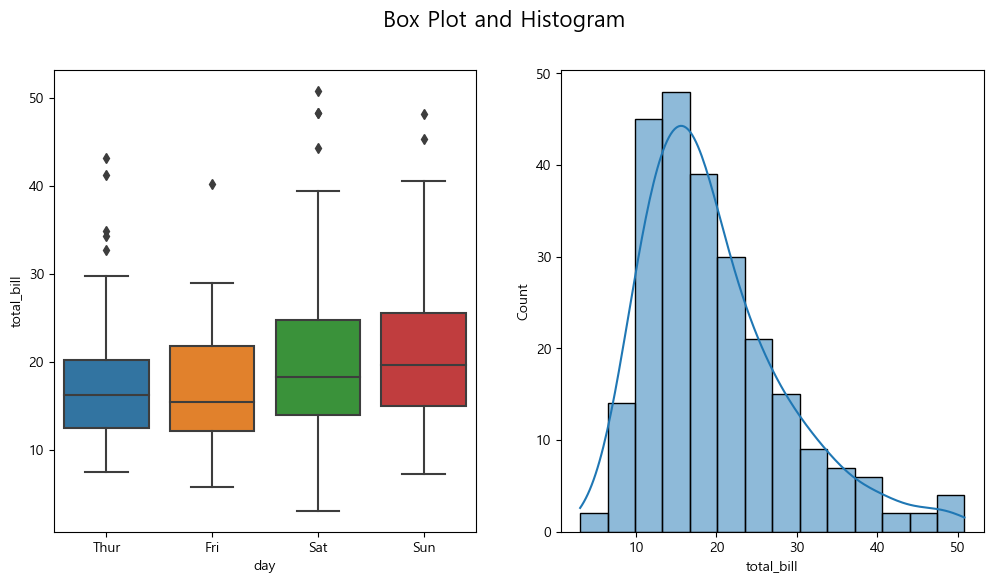

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

# 예제 데이터 생성
data = sns.load_dataset("tips")

# 박스 플롯과 히스토그램 같이 그리기
plt.figure(figsize=(12, 6))

# 박스 플롯
plt.subplot(1, 2, 1)
sns.boxplot(x="day", y="total_bill", data=data)

# 히스토그램
plt.subplot(1, 2, 2)
sns.histplot(data=data, x="total_bill", kde=True)

# 전체 차트의 제목 설정
plt.suptitle("Box Plot and Histogram", fontsize=16)

# 차트 보여주기
plt.show()

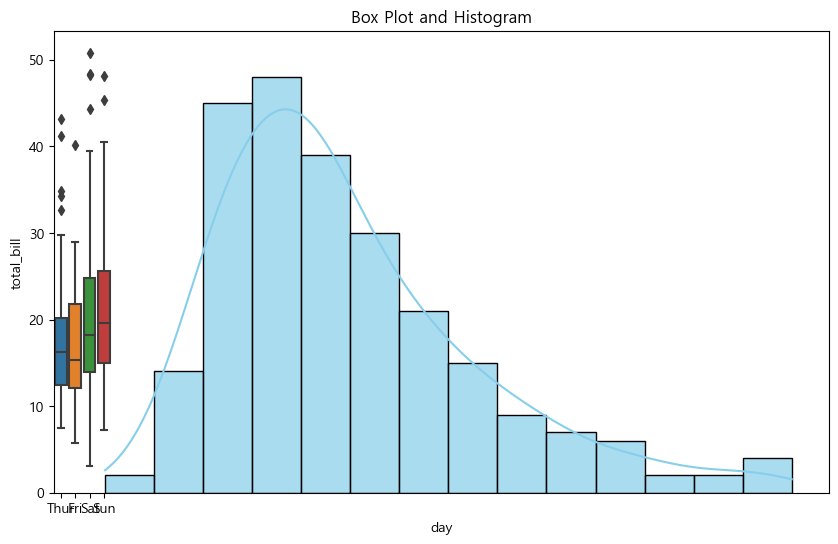

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

# 예제 데이터 생성
data = sns.load_dataset("tips")

# 박스 플롯과 히스토그램 같이 그리기
plt.figure(figsize=(10, 6))

# 박스 플롯
sns.boxplot(x="day", y="total_bill", data=data)

# 히스토그램
sns.histplot(data=data, x="total_bill", kde=True, color="skyblue", alpha=0.7)

# 차트 제목 설정
plt.title("Box Plot and Histogram")

# 차트 보여주기
plt.show()

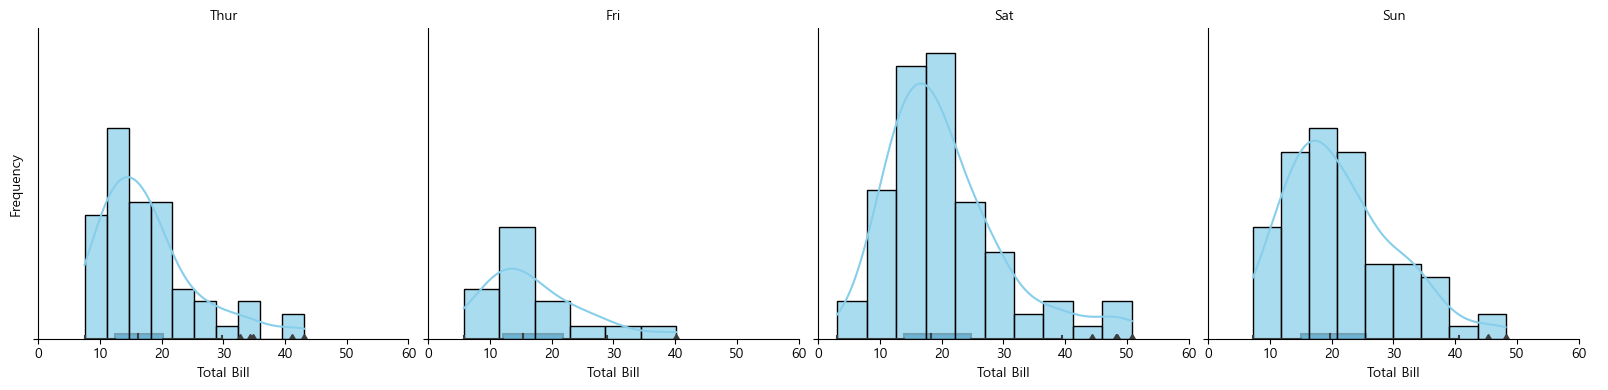

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

# 예제 데이터 생성
data = sns.load_dataset("tips")

# 박스 플롯과 히스토그램 같이 그리기
g = sns.FacetGrid(data, col="day", height=4, aspect=1)
g.map_dataframe(sns.boxplot, x="total_bill")
g.map_dataframe(sns.histplot, x="total_bill", kde=True, color="skyblue", alpha=0.7)
g.set_axis_labels("Total Bill", "Frequency")
g.set_titles(col_template="{col_name}")
g.set(ylim=(0, 25), xlim=(0, 60))
g.add_legend()

# 차트 보여주기
plt.show()

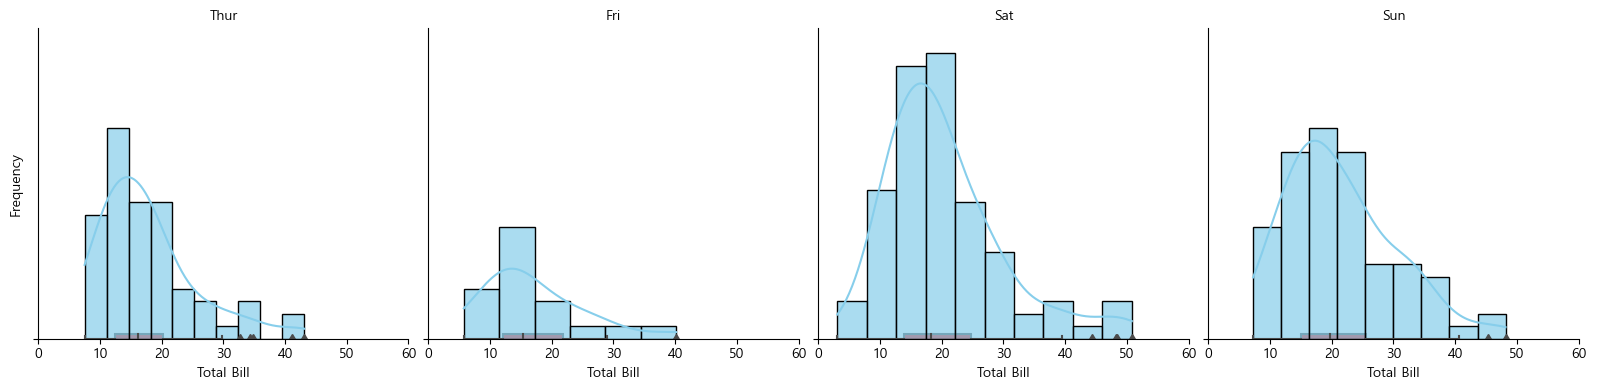

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

# 예제 데이터 생성
data = sns.load_dataset("tips")

# 박스 플롯과 히스토그램 같이 그리기
g = sns.FacetGrid(data, col="day", height=4, aspect=1)
g.map_dataframe(sns.boxplot, x="total_bill", color="red")
g.map_dataframe(sns.histplot, x="total_bill", kde=True, color="skyblue", alpha=0.7)
g.set_axis_labels("Total Bill", "Frequency")
g.set_titles(col_template="{col_name}")
g.set(ylim=(0, 25), xlim=(0, 60))
g.add_legend()

# 차트 보여주기
plt.show()

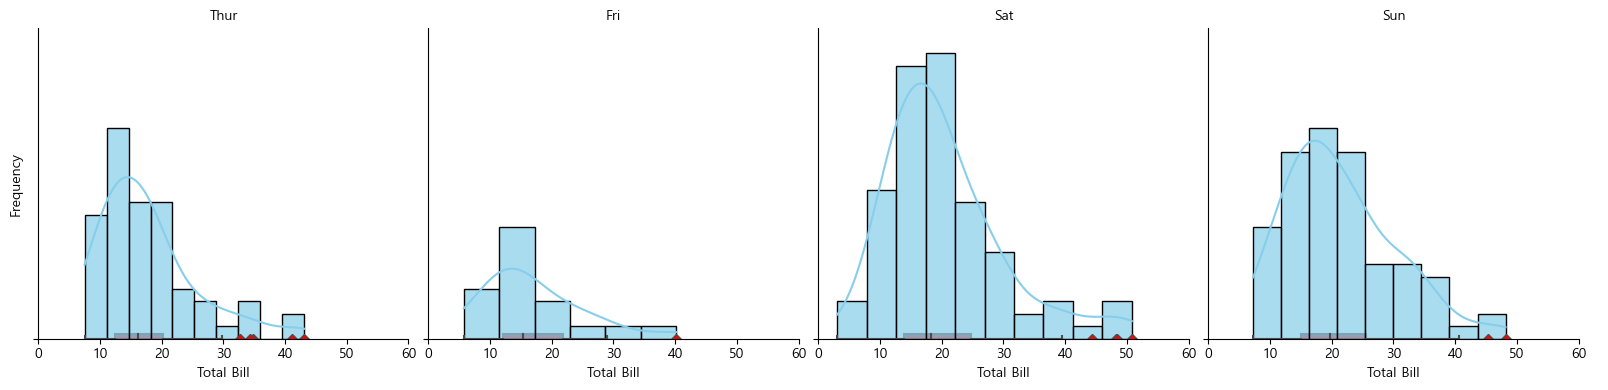

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

# 예제 데이터 생성
data = sns.load_dataset("tips")

# 박스 플롯과 히스토그램 같이 그리기
g = sns.FacetGrid(data, col="day", height=4, aspect=1)
g.map_dataframe(sns.boxplot, x="total_bill", color="red", flierprops=dict(markerfacecolor='red', marker='D'))
g.map_dataframe(sns.histplot, x="total_bill", kde=True, color="skyblue", alpha=0.7)
g.set_axis_labels("Total Bill", "Frequency")
g.set_titles(col_template="{col_name}")
g.set(ylim=(0, 25), xlim=(0, 60))
g.add_legend()

# 차트 보여주기
plt.show()

In [3]:
import plotly.express as px
import numpy as np

# 예제 데이터 생성
np.random.seed(42)
data = np.random.normal(size=(100,))

# Plotly를 사용하여 히스토그램과 박스플롯 함께 그리기
fig = px.histogram(data, nbins=20, marginal="box", labels={'value': 'Data'})

# 그래프 레이아웃 및 제목 설정
fig.update_layout(title_text='Histogram and Boxplot')

# 그래프 표시
fig.show()

In [4]:
import plotly.express as px
import plotly.graph_objects as go

# plotly.express에서 iris 데이터셋 로드
iris = px.data.iris()


# 각 종에 대한 기초 통계량 계산
statistics_df = iris.groupby('species')[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].describe().transpose()

print('1st_statistics_df',statistics_df)

# 튜플 대신 리스트 사용
statistics_df.columns = [col[0] for col in statistics_df.columns] #[col[1] for col in statistics_df.columns]

# Table trace 생성
table_trace = go.Table(
    header=dict(values=['통계량', 'setosa', 'versicolor', 'virginica']),
    cells=dict(values=[statistics_df.index] + [statistics_df[col].values for col in statistics_df.columns])
)

# Table 레이아웃 설정
table_layout = go.Layout(
    title='붓꽃 종 별 기초 통계량',
    height=500
)

# Table을 포함한 Figure 생성
table_fig = go.Figure(data=[table_trace], layout=table_layout)

# Figure 표시
table_fig.show()

1st_statistics_df species                setosa  versicolor  virginica
sepal_length count  50.000000   50.000000  50.000000
             mean    5.006000    5.936000   6.588000
             std     0.352490    0.516171   0.635880
             min     4.300000    4.900000   4.900000
             25%     4.800000    5.600000   6.225000
             50%     5.000000    5.900000   6.500000
             75%     5.200000    6.300000   6.900000
             max     5.800000    7.000000   7.900000
sepal_width  count  50.000000   50.000000  50.000000
             mean    3.418000    2.770000   2.974000
             std     0.381024    0.313798   0.322497
             min     2.300000    2.000000   2.200000
             25%     3.125000    2.525000   2.800000
             50%     3.400000    2.800000   3.000000
             75%     3.675000    3.000000   3.175000
             max     4.400000    3.400000   3.800000
petal_length count  50.000000   50.000000  50.000000
             mean    1.46400

NameError: name 'col' is not defined

In [2]:
statistics_df

e          e          i
sepal_length count  50.000000  50.000000  50.000000
             mean    5.006000   5.936000   6.588000
             std     0.352490   0.516171   0.635880
             min     4.300000   4.900000   4.900000
             25%     4.800000   5.600000   6.225000
             50%     5.000000   5.900000   6.500000
             75%     5.200000   6.300000   6.900000
             max     5.800000   7.000000   7.900000
sepal_width  count  50.000000  50.000000  50.000000
             mean    3.418000   2.770000   2.974000
             std     0.381024   0.313798   0.322497
             min     2.300000   2.000000   2.200000
             25%     3.125000   2.525000   2.800000
             50%     3.400000   2.800000   3.000000
             75%     3.675000   3.000000   3.175000
             max     4.400000   3.400000   3.800000
petal_length count  50.000000  50.000000  50.000000
             mean    1.464000   4.260000   5.552000
             std     0.173511   0.469911   0.551895
             min     1.000000   3.000000   4.500000
             25%     1.400000   4.000000   5.100000
             50%     1.500000   4.350000   5.550000
             75%     1.575000   4.600000   5.875000
             max     1.900000   5.100000   6.900000
petal_width  count  50.000000  50.000000  50.000000
             mean    0.244000   1.326000   2.026000
             std     0.107210   0.197753   0.274650
             min     0.100000   1.000000   1.400000
             25%     0.200000   1.200000   1.800000
             50%     0.200000   1.300000   2.000000
             75%     0.300000   1.500000   2.300000
             max     0.600000   1.800000   2.500000

In [ ]:

# 각 종에 대한 기초 통계량 계산
statistics_df = iris.groupby('species')[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].describe().transpose()

# 튜플 대신 리스트 사용
statistics_df.columns = [col[1] for col in statistics_df.columns]

# Table trace 생성
table_trace = go.Table(
    header=dict(values=['통계량', 'setosa', 'versicolor', 'virginica']),
    cells=dict(values=[statistics_df.index] + [statistics_df[col].values for col in statistics_df.columns])
)

# Table 레이아웃 설정
table_layout = go.Layout(
    title='붓꽃 종 별 기초 통계량',
    height=500
)

# Table을 포함한 Figure 생성
table_fig = go.Figure(data=[table_trace], layout=table_layout)

# Figure 표시
table_fig.show()

In [93]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import ttest_ind

# 예제 데이터 생성 (데이터프레임 형태)
# 여기서는 단순 예제로서 feature들이 'X1', 'X2', 'X3', ... 형태로 되어 있다고 가정합니다.
# 실제 데이터에 맞게 수정하셔야 합니다.
data = pd.DataFrame({
    'X1': [1, 2, 3, 4, 5],
    'X2': [5, 4, 3, 2, 1],
    'X3': [10, 8, 6, 4, 2],
    'Target': [20, 25, 30, 35, 40]  # 예측하고자 하는 대상 변수
})

# Features와 Target으로 데이터 나누기
X = data.drop('Target', axis=1)
y = data['Target']

# Train/Test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForestRegressor 모델 생성 및 학습
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Feature Importance 추출
feature_importance = model.feature_importances_

# Feature Importance가 높은 Feature 선택
selected_feature = X.columns[feature_importance.argmax()]

# A/B 테스트 그룹 및 대조 그룹 생성
test_group = data[data[selected_feature] > data[selected_feature].median()]
control_group = data[data[selected_feature] <= data[selected_feature].median()]

# A/B 테스트 수행 (예시로 평균 비교)
test_statistic, p_value = ttest_ind(test_group['Target'], control_group['Target'])

# A/B 테스트 결과 출력
print(f"Selected Feature: {selected_feature}")
print(f"A/B Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")

# P-value를 통해 유의수준을 확인하고 결과를 해석
alpha = 0.05
if p_value < alpha:
    print("Statistically significant difference detected! Implement the change.")
else:
    print("No statistically significant difference. Do not implement the change.")

Selected Feature: X1
A/B Test Statistic: 3.0000000000000004
P-value: 0.05766888562243725
No statistically significant difference. Do not implement the change.


In [100]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import ttest_ind

# 예제 데이터 생성 (데이터프레임 형태)
# 여기서는 단순 예제로서 feature들이 'X1', 'X2', 'X3', ... 형태로 되어 있다고 가정합니다.
# 실제 데이터에 맞게 수정하셔야 합니다.
data = pd.DataFrame({
    'X1': [1, 2, 3, 4, 5],
    'X2': [5, 4, 3, 2, 1],
    'X3': [10, 8, 6, 4, 2],
    'X4' : [0.3,7777,1, 1.1,1.4],
    'Target': [20, 25, 30, 35, 40]  # 예측하고자 하는 대상 변수
})

# Features와 Target으로 데이터 나누기
X = data.drop('Target', axis=1)
y = data['Target']

# Train/Test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForestRegressor 모델 생성 및 학습
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Feature Importance 추출
feature_importance = model.feature_importances_
print('feature_importance 리스트 보기 : ', feature_importance)
# Feature Importance가 높은 Feature 선택
selected_features = X.columns[feature_importance.argsort()[::-1]]



# 각 Feature를 기준으로 A/B 테스트 수행
alpha = 0.05
for feature in selected_features:
    # A/B 테스트 그룹 및 대조 그룹 생성
    test_group = data[data[feature] > data[feature].median()]
    control_group = data[data[feature] <= data[feature].median()]
    
    print(f"test_group: {test_group}")
    print(f"control_group: {control_group}")    

    # A/B 테스트 수행 (예시로 평균 비교)
    test_statistic, p_value = ttest_ind(test_group['Target'], control_group['Target'])

    # A/B 테스트 결과 출력
    print(f"Selected Feature: {feature}")
    print(f"A/B Test Statistic: {test_statistic}")
    print(f"P-value: {p_value}")

    # P-value를 통해 유의수준을 확인하고 결과를 해석
    if p_value < alpha:
        print("Statistically significant difference detected! Implement the change.")
    else:
        print("No statistically significant difference. Do not implement the change.")
    print("-" * 50)

feature_importance 리스트 보기 :  [0.23571699 0.25611267 0.22192029 0.28625005]
test_group:    X1  X2  X3      X4  Target
1   2   4   8  7777.0      25
4   5   1   2     1.4      40
control_group:    X1  X2  X3   X4  Target
0   1   5  10  0.3      20
2   3   3   6  1.0      30
3   4   2   4  1.1      35
Selected Feature: X4
A/B Test Statistic: 0.5222329678670936
P-value: 0.6376180914006017
No statistically significant difference. Do not implement the change.
--------------------------------------------------
test_group:    X1  X2  X3      X4  Target
0   1   5  10     0.3      20
1   2   4   8  7777.0      25
control_group:    X1  X2  X3   X4  Target
2   3   3   6  1.0      30
3   4   2   4  1.1      35
4   5   1   2  1.4      40
Selected Feature: X2
A/B Test Statistic: -3.0000000000000004
P-value: 0.05766888562243725
No statistically significant difference. Do not implement the change.
--------------------------------------------------
test_group:    X1  X2  X3   X4  Target
3   4   2   4  1